# Dynamics and Static Structure of Dipolar Microswimmers under an External Field

**Jesús D. Medel**  
Master’s in Applied Physics  
Faculty of Physical and Mathematical Sciences (FCFM), BUAP  
Master’s Thesis – June 2025  

**Thesis Advisor:** Dr. Roberto Ramírez  

## Abstract

At the microscale, microswimmers have gained attention due to their potential applications in biomedicine, technology, and manufacturing. This thesis presents a computational study of the dynamic and structural properties of a quasi-two-dimensional system of 100 dipolar Janus microswimmers under a constant magnetic field. Using Brownian Dynamics simulations, the influence of the field is analyzed in terms of dynamic and structural properties such as the translational and rotational mean squared displacement (MSD) and the static structure factor. The model includes interactions via Weeks-Chandler-Andersen (WCA) potential and dipolar forces, but neglects hydrodynamic effects, considering that the clusters formed do not reach a sufficient size for such effects to be significant. The validity of the simulation is verified by comparing the MSD in the weak interaction regime with the theoretical solution from the Smoluchowski formalism. Data processing and analysis are performed in Python. The results show that the most efficient dynamics—characterized by greater alignment with the field and reduced aggregation—are achieved with low dipolar moments and greater initial separation. These conditions allow the field to reorient the microswimmers without hindering their self-propulsion in a single direction, enabling effective control of the system with minimal external intervention.

*Keywords*: _microswimmer, Janus particle, Brownian dynamics, magnetic dipole, Smoluchowski equation, field-induced orientation, active matter._

## 1. Imports

In [2]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import final_functions as f

c:\Users\iesus\Downloads\final_functions.py:1959: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('m = $\sqrt{10}m_0$\nDensity', fontsize=fontsize)


## 2. Parameters

In [ ]:
# PARAMETERS

# Number of particles
N = 100

# Number of steps
steps = 100_000

# Time step size in seconds
dt = 1e-4

# Number of times the experiment is repeated
iterations = 50
batch_size = 1000

# Particle diameter (m)
sigma = 1e-6    

# Solvent temperature (K)
T = 300         

# Solvent viscosity (Pa s)
eta = 1e-3      

# Magnetic permeability of the medium (H/m)
mu = 1.257e-6                        

# Magnitude of the particle's dipole moment (A m^2)
mm = 1.15e-16 * 2 * np.sqrt(10)

# Values of the external magnetic field (T)
B_values = [0, 0.0001, 0.001, 0.01]
n_steps_values = [1, int(steps // 10_000), int(steps // 1_000), int(steps // 100), int(steps // 10), steps]

# Particle velocity (m/s)
v = 10 * sigma

# Maximum random position (for isotropic phase particles)
max_pos = 100 * sigma                     

# Separation between particles (in sigma) for initial grid configuration
separation = 1
separation_values = [1,2]

# Initial grid configuration
initial_grid_config = True
n_rows = 10
n_cols = 10

if initial_grid_config:
    if n_rows * n_cols != N:
        raise ValueError("The number of rows and columns must be equal to the number of particles")

# Initial angle (None for random)
initial_angle = None

# Brownian motion: 0 to deactivate, 1 to activate
brownian_motion = True                             

# Number of the steps to skip in the MSD calculation
skip_fraction = 0

In [7]:
# Boltzmann constant (J/K)
k = 1.38e-23   
K0 = k * T
Dt = k * T / (6 * np.pi * eta * sigma)
Dr = k * T / (np.pi * eta * sigma ** 3)

print(f'ε = {(mu * mm ** 2 / (4 * np.pi * sigma ** 3)) * 1:.2e} J')
print(f'Dimensionless dipole moment {np.sqrt(mm**2 / (K0 * sigma**3)): .2e}')
print(f'Dt = {Dt:.2e} m^2/s')
print(f'Dr = {Dr:.2e} 1/s')
print(f'Time: {dt*steps} s')

ε = 5.29e-20 J
Dimensionless dipole moment  1.13e+04
Dt = 2.20e-13 m^2/s
Dr = 1.32e+00 1/s
Time: 10.0 s


## 3. Interaction Potential

<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
C:\Users\iesus\AppData\Local\Temp\ipykernel_19000\2489233500.py:43: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('r ($\sigma$)', fontsize=fontsize)


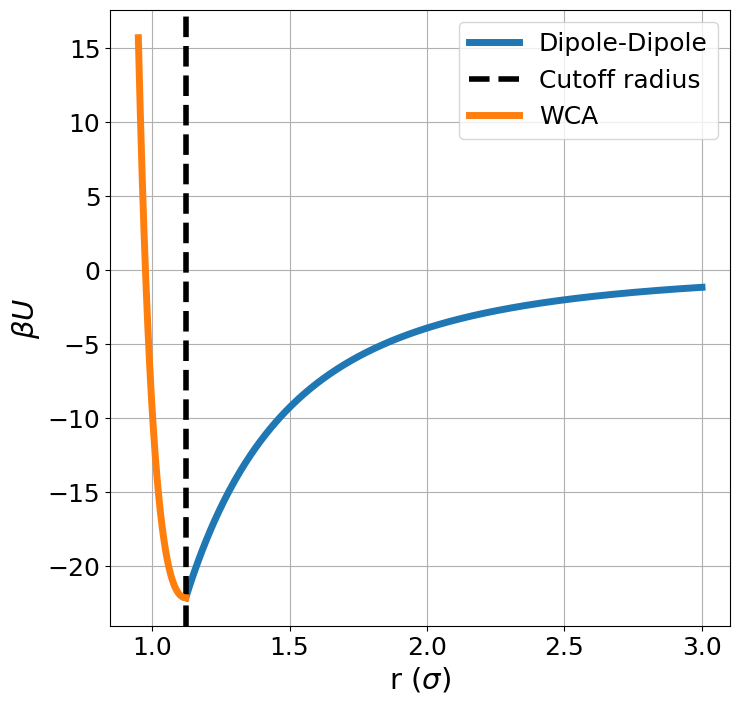

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm

epsilon = mm**2 / sigma**3
m_star = np.sqrt(mu * mm**2 / (k * T * sigma**3))
rc = 2**(1/6)

# Define the WCA potential
def UWCA(r):
    return (mu / (4 * np.pi)) * (4 * epsilon * ((1 / r)**12 - (1 / r)**6) + epsilon) / (k * T)

# Define the dipole-dipole potential
def U(r):
    return -np.sqrt((8 * np.pi) / 15) * m_star**2 / r**3

# V function with spherical harmonics and Clebsch-Gordan coefficients (approximation without non-physical terms)
def V(r, alpha, gamma, beta, eta, theta, phi):
    Y1_k = sph_harm(0, 1, alpha, gamma).real  # Spherical harmonic Y1_k
    Y1_l = sph_harm(0, 1, beta, eta).real  # Spherical harmonic Y1_l
    Y2_m = sph_harm(0, 2, theta, phi).real  # Complex conjugate Spherical harmonic Y2_m
    return U(r) * (Y1_k * Y1_l * Y2_m)  # Approximation without Clebsch-Gordan

# Range for the dipole-dipole potential
dr_values = np.linspace(rc, 3, 500)
V_values = np.array([V(r, np.pi/2, 0, np.pi/2, 0, np.pi/2, 0) for r in dr_values])

# Plot the WCA potential
fontsize = 21
linewidth = 5
plt.figure(figsize=(8, 8))
plt.plot(dr_values, V_values, label='Dipole-Dipole', linewidth=linewidth)

# Cutoff radius
plt.axvline(x=rc, color='k', linestyle='dashed', label='Cutoff radius', linewidth=linewidth-1)

# Range of values for r
r_values = np.linspace(0.95, rc, 500)
UWCA_values = np.array([UWCA(r) for r in r_values])

# Plot the dipole-dipole potential
plt.plot(r_values, UWCA_values + V_values[0], label='WCA', linewidth=linewidth)
plt.xlabel('r ($\sigma$)', fontsize=fontsize)
plt.ylabel('$βU$', fontsize=fontsize)
plt.xticks(fontsize=fontsize-3)
plt.yticks(fontsize=fontsize-3)
plt.legend(fontsize=fontsize-3)
plt.grid()
plt.show()


In [8]:
# Evaluate the potential at a specific distance
r_cl = 3.97 # Distance

if r_cl >= rc:
    print(f"r = {r_cl}σ")
    print(f"U_DD = {V(r_cl, np.pi/2, 0, np.pi/2, 0, np.pi/2, 0):.3f}")

else:
    print(f"r = {r}σ")
    print(f"U_WCA = {UWCA(r) + V_values[0]:.3f}")

r = 3.97σ
U_DD = -0.500


## 4. Discretized Solution of Langevin Equations and Data Generation

In [ ]:
# Generate initial conditions for the particles
"""for separation in separation_values:
    # Generate initial conditions
    filename = f.generate_initial_conditions(N, steps, iterations, max_pos= np.sqrt(N), separation=separation, 
                                                initial_grid_config=initial_grid_config, 
                                                n_rows=n_rows, n_cols=n_cols, initial_angle=initial_angle, 
                                                sigma=sigma, 
                                                show_data=True, plot_configuration=True
                                            )"""

'for separation in separation_values:\n    # Generate initial conditions\n    filename = f.generate_initial_conditions(N, steps, iterations, max_pos= np.sqrt(N), separation=separation, \n                                                initial_grid_config=initial_grid_config, \n                                                n_rows=n_rows, n_cols=n_cols, initial_angle=initial_angle, \n                                                sigma=sigma, \n                                                show_data=True, plot_configuration=True\n                                            )'

In [ ]:
# Solve equations for different values of B
"""for separation in separation_values:
    filename = f'initial_conditions_{N}part_{steps // 1000}ksteps_{iterations}its_{separation}sep.csv'

    for B in B_values:   
        # Solve equations for different values of B
        f.solve_equations(N, steps, iterations, separation, 
                            sigma, B, mm, v, dt, mu, eta, T, brownian_motion, 
                            initial_conditions_file=filename, batch_size=batch_size
                    )

    print(f'Finished separation {separation}')"""

"for separation in separation_values:\n    filename = f'initial_conditions_{N}part_{steps // 1000}ksteps_{iterations}its_{separation}sep.csv'\n\n    for B in B_values:   \n        # Solve equations for different values of B\n        f.solve_equations(N, steps, iterations, separation, \n                            sigma, B, mm, v, dt, mu, eta, T, brownian_motion, \n                            initial_conditions_file=filename, batch_size=batch_size\n                    )\n\n    print(f'Finished separation {separation}')"

## 5. Dynamics Analysis

### 5.1. Initial Configurations

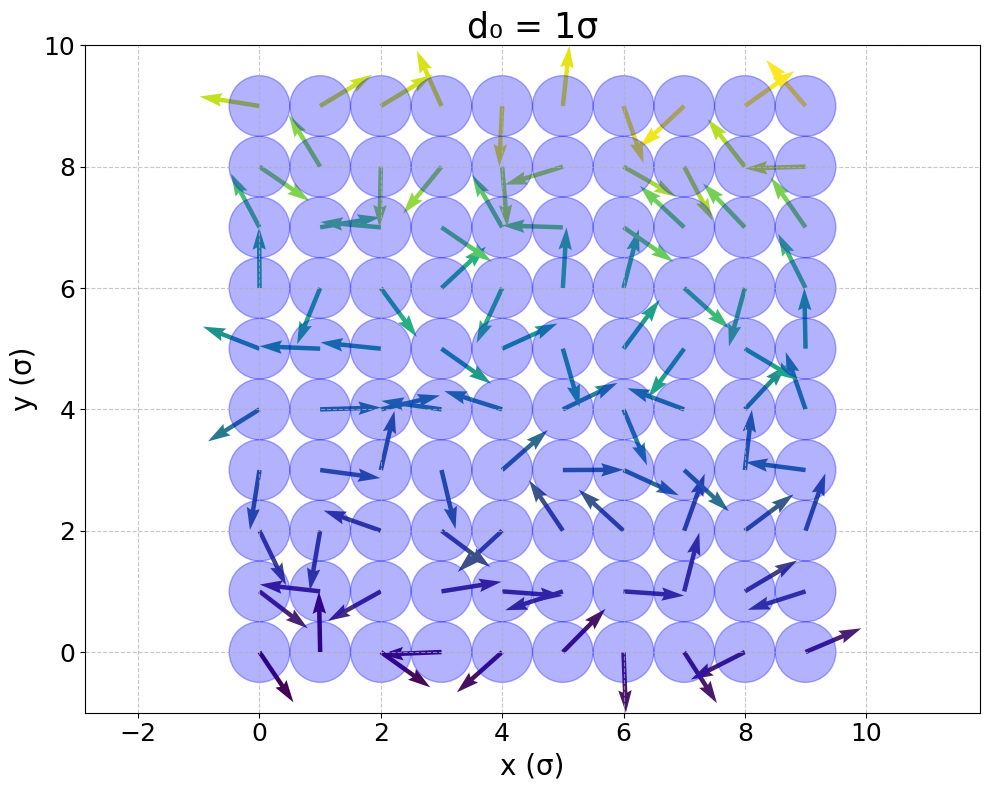

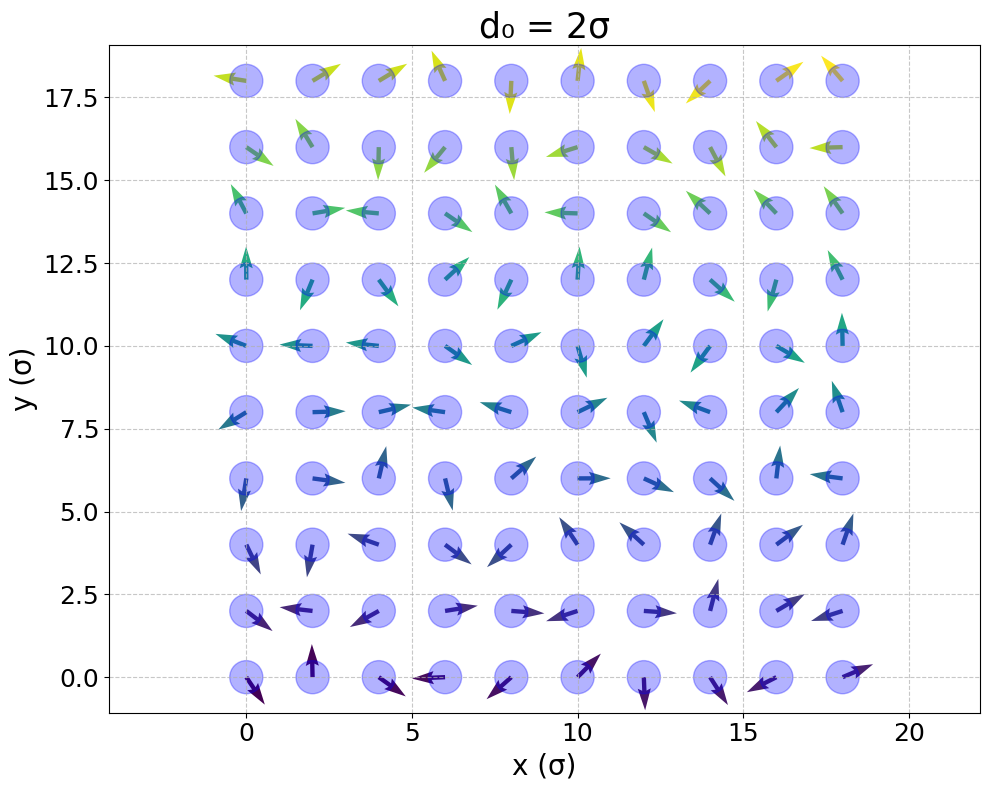

In [ ]:
# Plot initial configuration
for separation in separation_values:
    f.plot_initial_configuration(N, steps, iterations, separation, sigma, B_values[0], arrow_scale=1)

### 5.2. Plot Trajectories

#### 5.2.1. Specific trajectory (`it=1`)

d₀ = 1σ


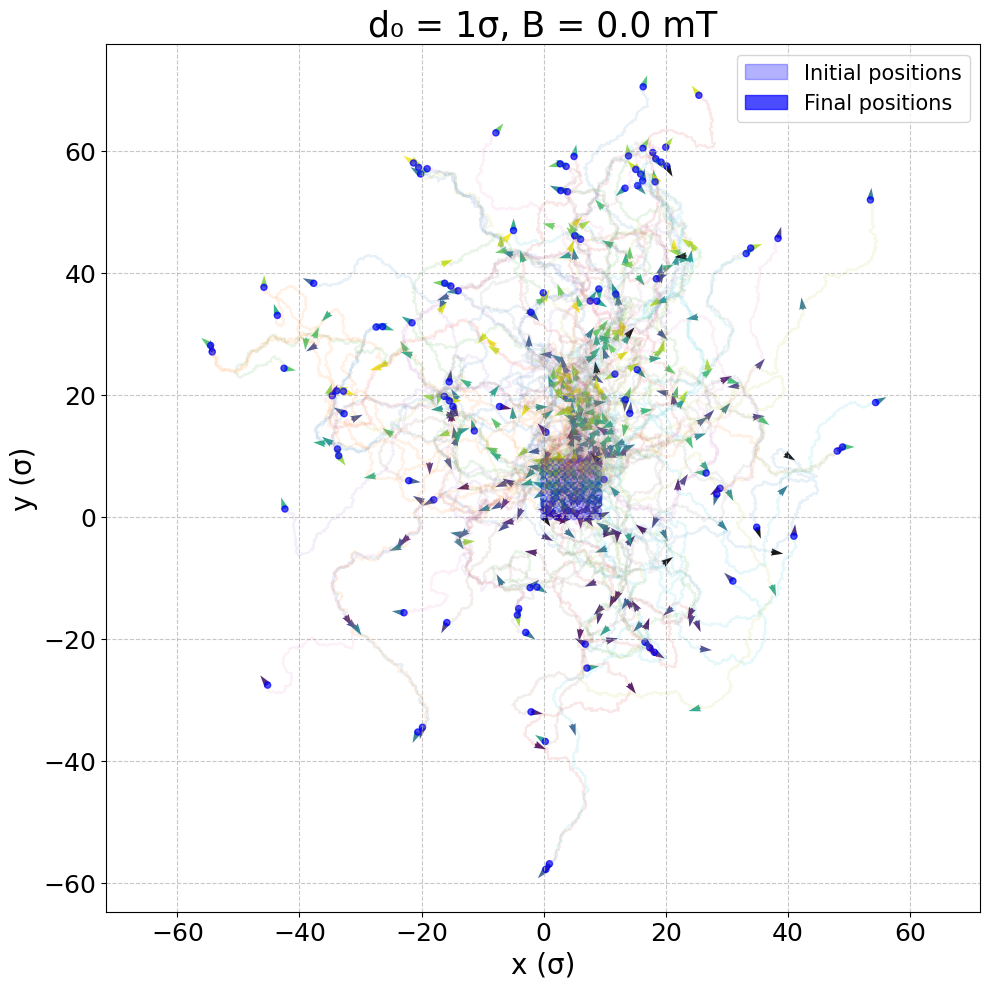

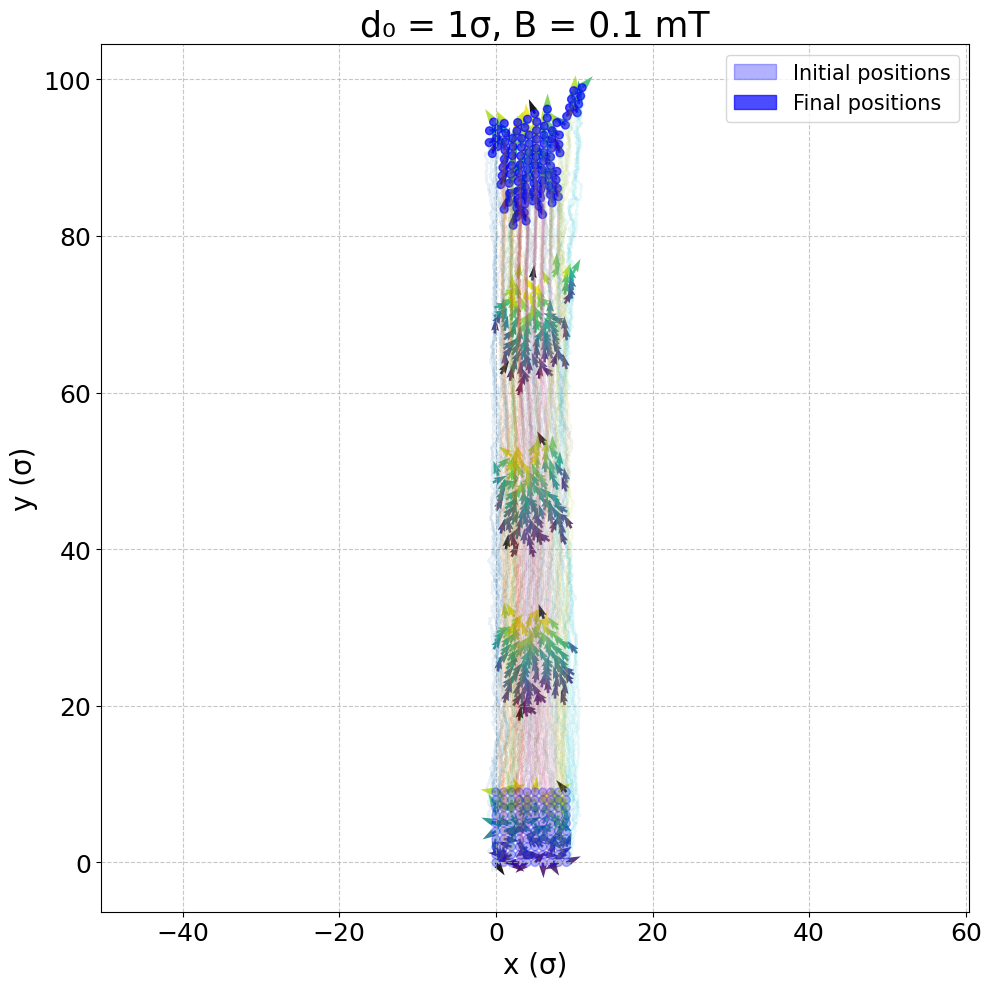

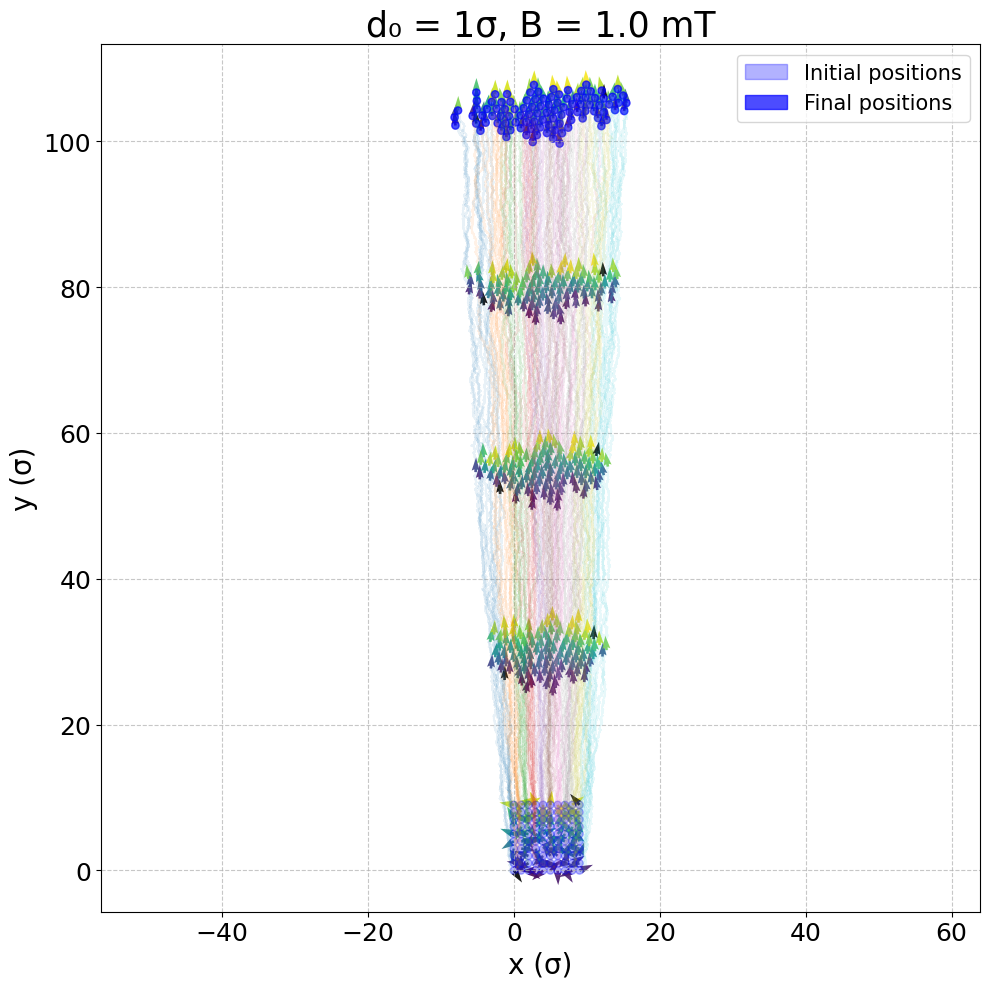

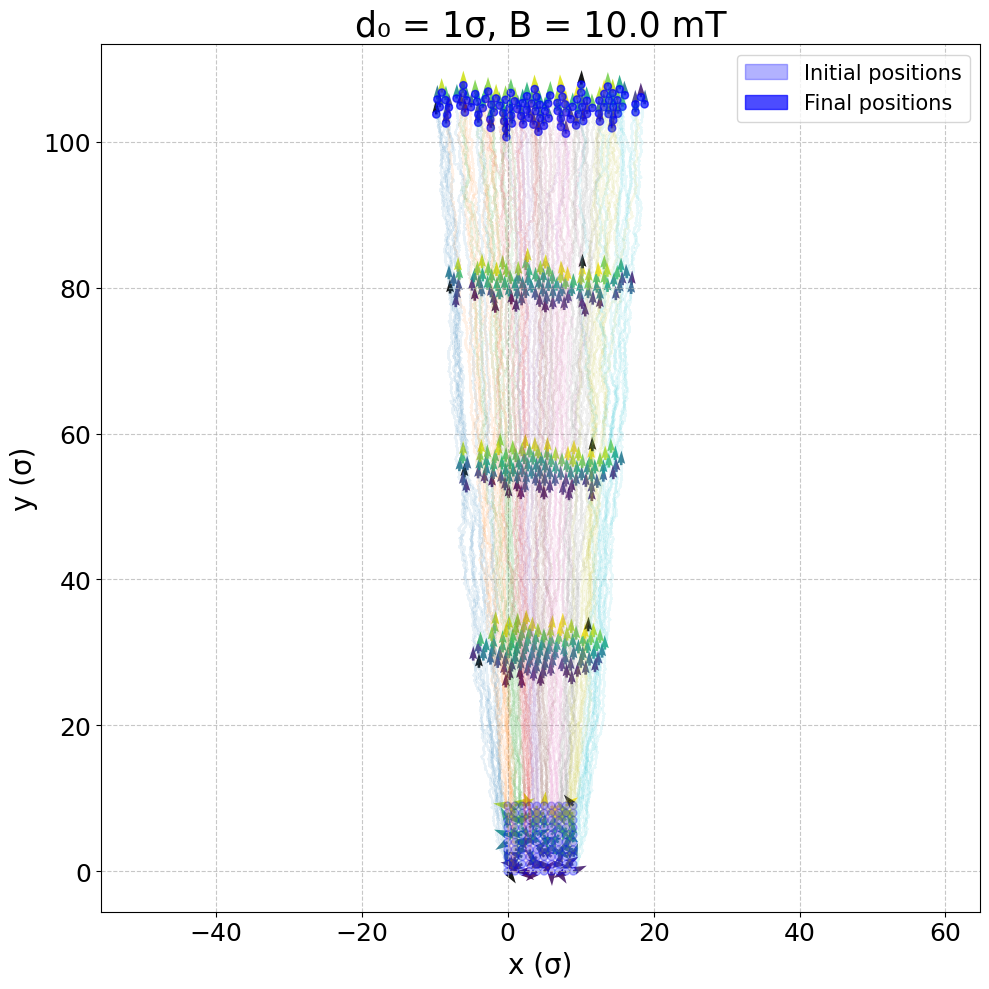

d₀ = 2σ


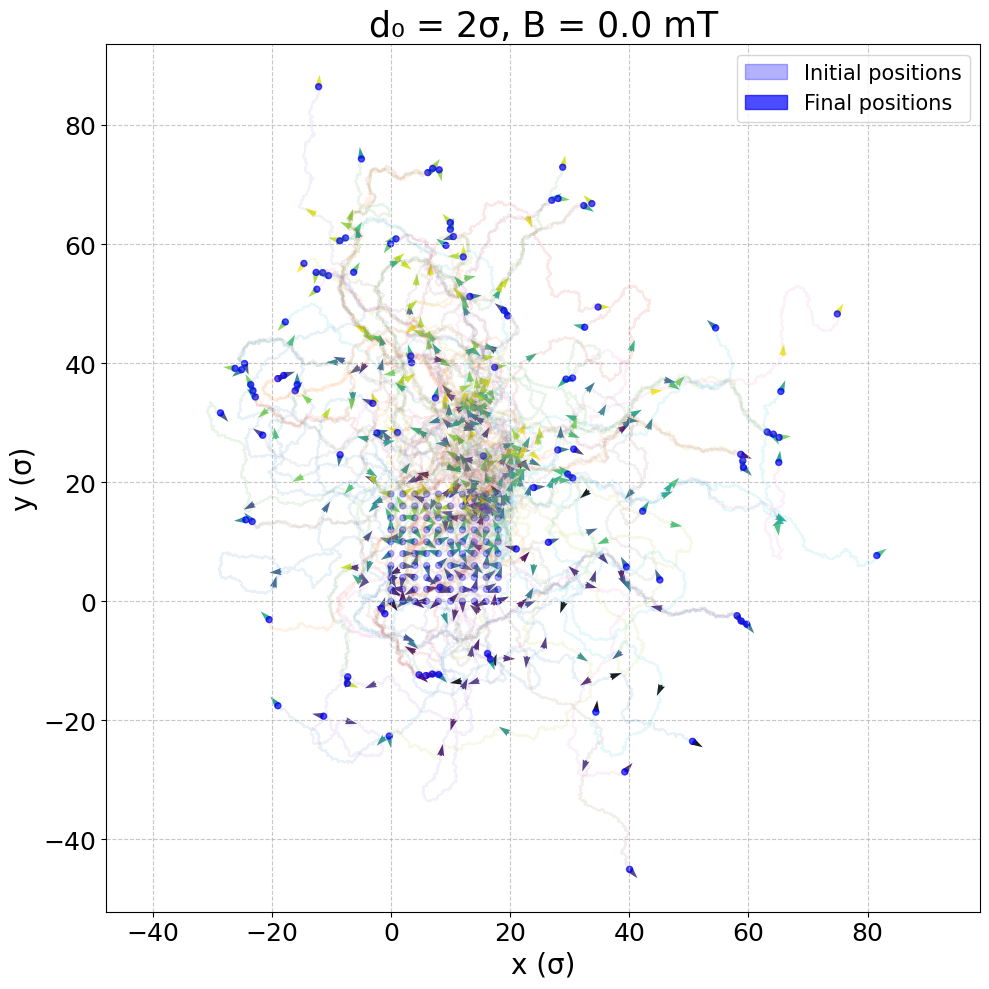

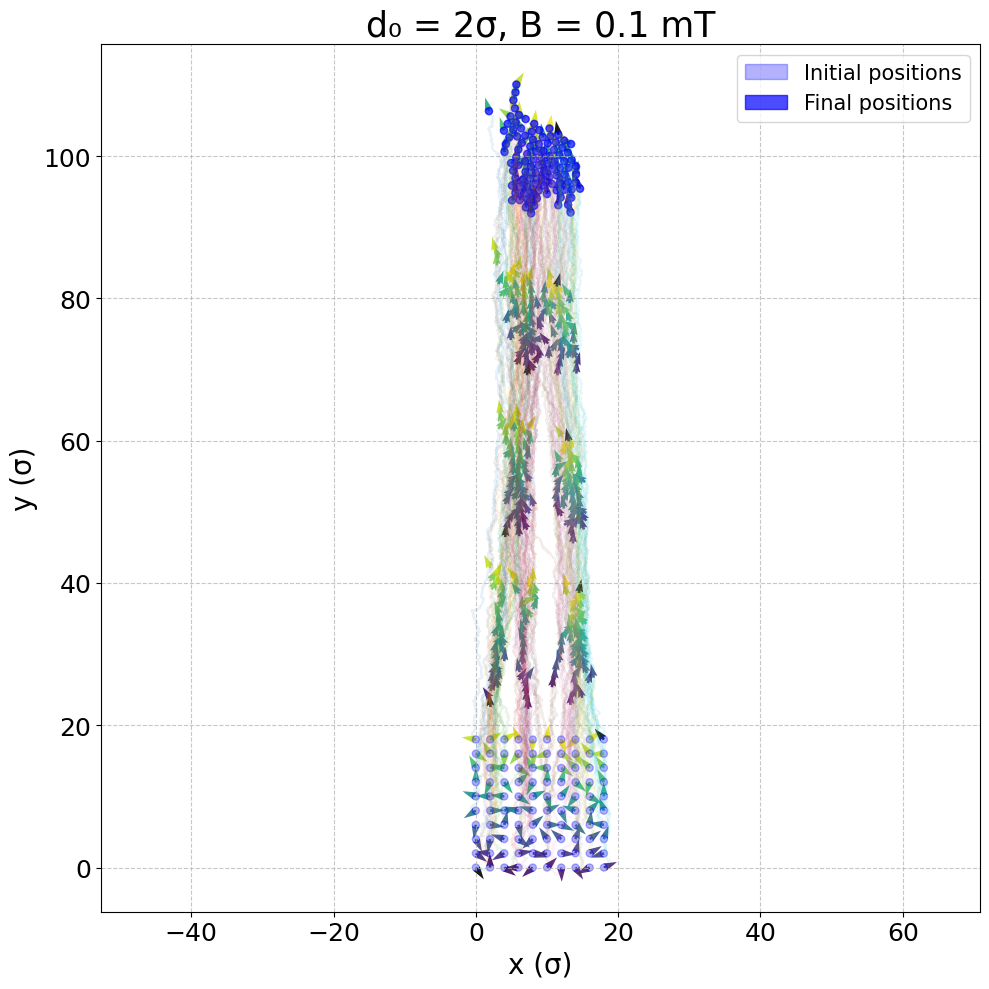

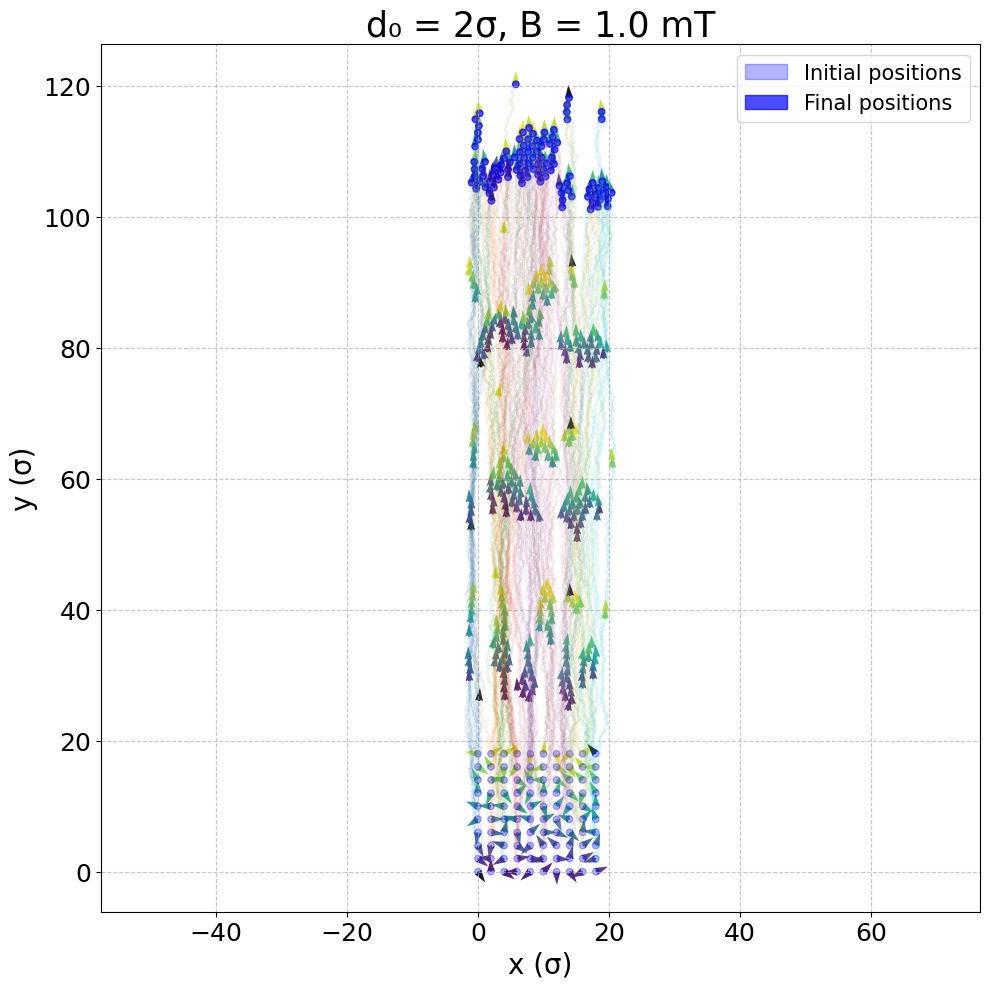

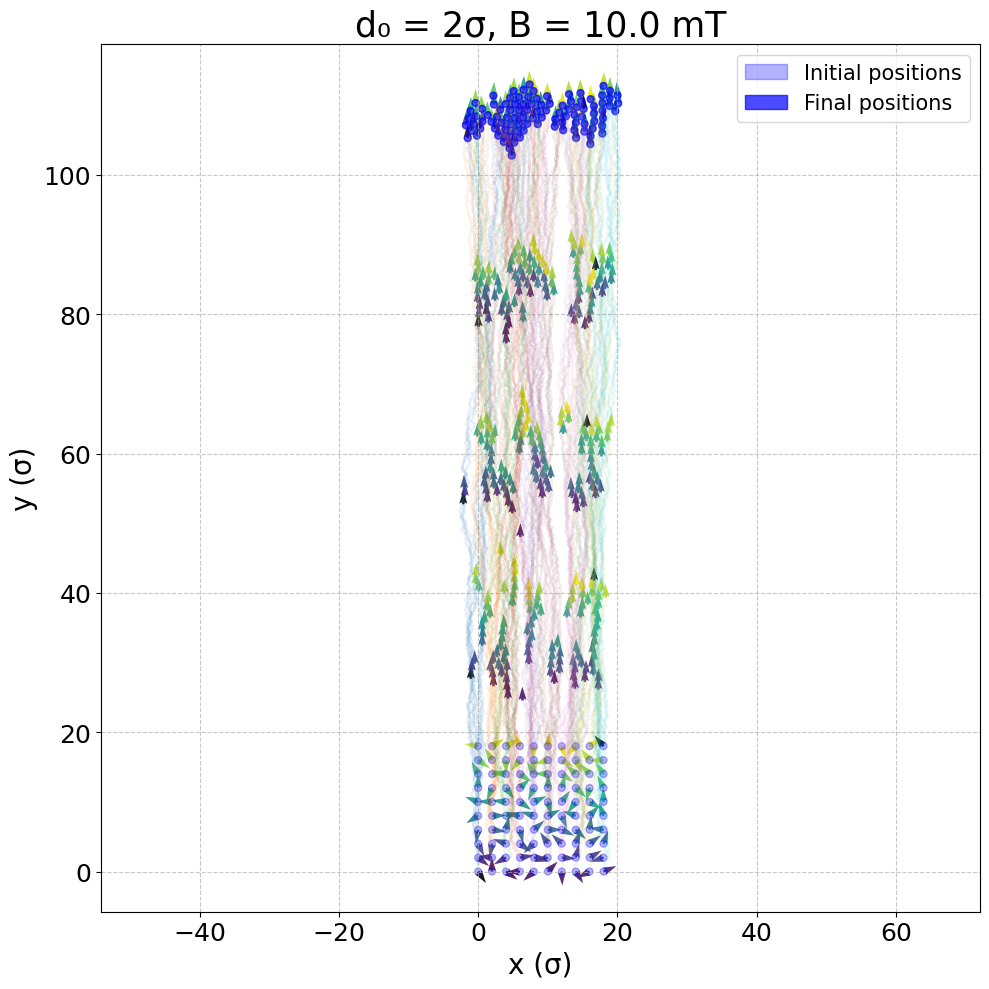

In [ ]:
# Plot trajectories for different values of B
for separation in separation_values:
    print(f'd₀ = {separation}σ')
    for B in B_values:
        f.plot_trajectories(N, steps, iterations=iterations, separation=separation, dt=dt, 
                            sigma=sigma, v=v, B=B, mm=mm, T=T, 
                            brownian_motion=brownian_motion, arrow_scale=0.5
                            )

### 5.2. Mean final positions and angles vs Magnetic field

In [ ]:
# Get displacement data
displacement_data = f.gather_displacement_data(B_values, steps, iterations, separation_values, sigma, N)

Saved aggregated data to aggregated_displacements.csv


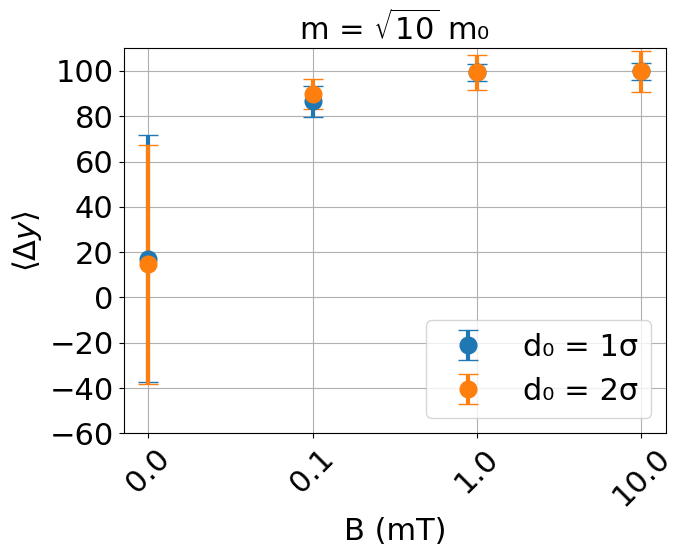

In [ ]:
# Plot displacement data
f.plot_displacement_data(v, sigma, dipole_moment='sqrt10', figsize=(7,5))

In [ ]:
# Gather and final angle data
final_angle_data = f.gather_final_angles(B_values, steps, iterations, separation_values, N)

Saved aggregated data to aggregated_final_angles.csv


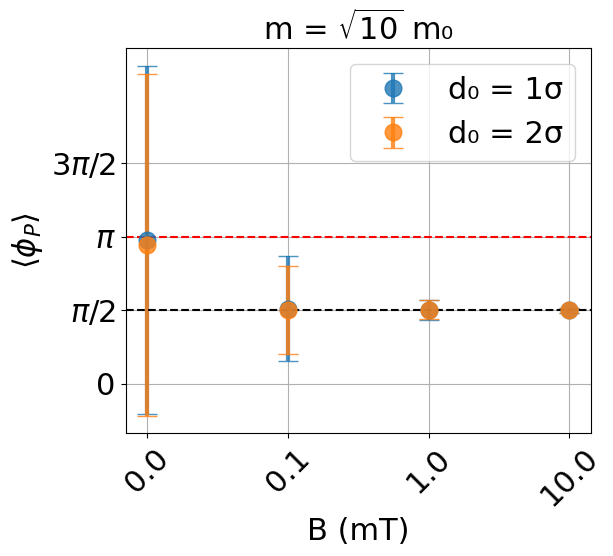

In [ ]:
# Plot final angles
f.plot_final_angles(dipole_moment='sqrt10', figsize=(6,5))

### 5.4 MSD

#### 5.4.1. Translational

In [9]:
# Calculate the MSD
"""for separation in separation_values:
    f.calculate_MSD(N, steps, iterations, separation, 
                      sigma, dt, B_values, v, eta, T, 
                      type_msd='tra', skip_fraction=0.001)"""

"for separation in separation_values:\n    f.calculate_MSD(N, steps, iterations, separation, \n                      sigma, dt, B_values, v, eta, T, \n                      type_msd='tra', skip_fraction=0.001)"

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\iesus\AppData\Local\Temp\ipykernel_15384\2160587596.py:10: SyntaxWarning: invalid escape sequence '\s'
  type_msd='tra', loglog=True, start=0, end=None, figsize=(8,6), dipole_moment='$\sqrt{{10}}$', legend=legend)


d₀ = 1σ


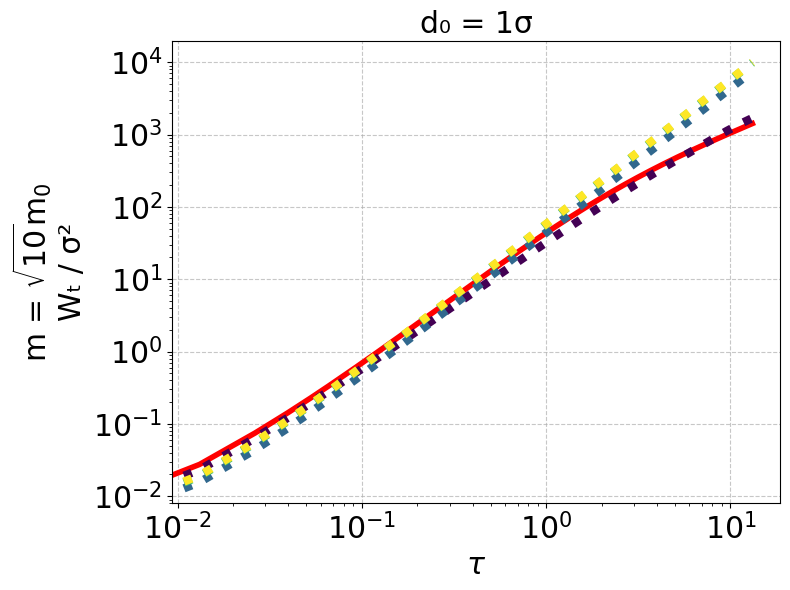

d₀ = 2σ


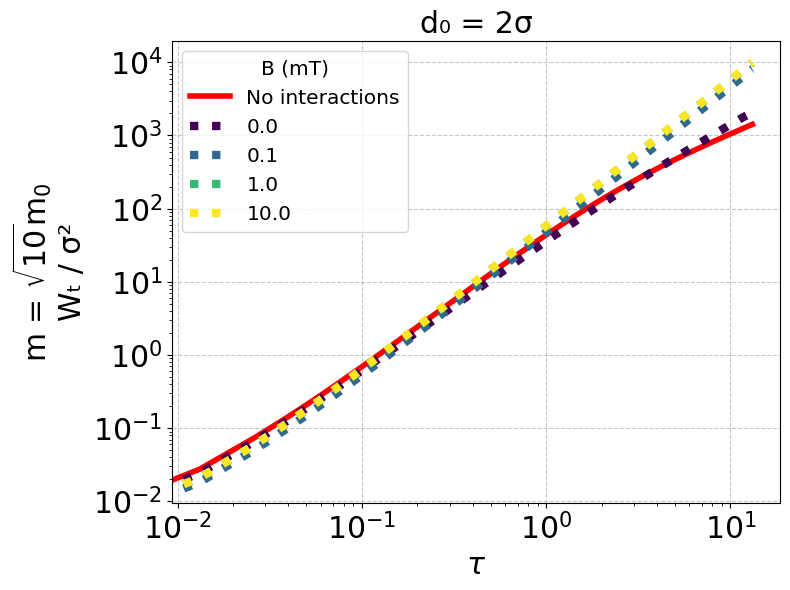

In [ ]:
# Plot the MSD for translational motion
for separation in separation_values:
    print(f'd₀ = {separation}σ')
    if separation==1:
        legend = False
    elif separation==2:
        legend = True
    f.plot_MSD(N, steps, iterations, separation, B_values, 
             sigma, v, T, eta,
             type_msd='tra', loglog=True, start=0, figsize=(8,6), dipole_moment='$\sqrt{{10}}$', legend=legend)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\iesus\AppData\Local\Temp\ipykernel_15384\3646219851.py:6: SyntaxWarning: invalid escape sequence '\s'
  type_msd='tra', loglog=True, start=0, end=15, figsize=(3,2), dipole_moment='$\sqrt{{10}}$', label=False)


d₀ = 1σ


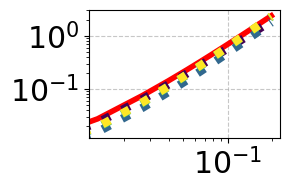

d₀ = 2σ


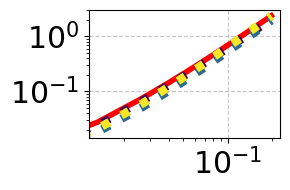

In [ ]:
# Plot the MSD for translational motion
for separation in separation_values:
    print(f'd₀ = {separation}σ')
    f.plot_MSD(N, steps, iterations, separation, B_values, 
             sigma, v, T, eta,
             type_msd='tra', loglog=True, start=0, end=15, figsize=(3,2), dipole_moment='$\sqrt{{10}}$', label=False)

#### 5.4.2. Rotational

In [ ]:
# Calculate the MSD for rotational motion
"""for separation in separation_values:
    print(f'd₀ = {separation}σ')    
    f.calculate_MSD(N, steps, iterations, separation, 
                  sigma, dt, B_values, v, eta, T, 
                  type_msd='rot', skip_fraction=0.0001)"""

"# Calculate the MSD\nfor separation in separation_values:\n    print(f'd₀ = {separation}σ')    \n    f.calculate_MSD(N, steps, iterations, separation, \n                  sigma, dt, B_values, v, eta, T, \n                  type_msd='rot', skip_fraction=0.0001)"

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
C:\Users\iesus\AppData\Local\Temp\ipykernel_11420\3285356410.py:16: SyntaxWarning: invalid escape sequence '\s'
  type_msd='rot', loglog=True, start=1, end=5_500, figsize=(8.5,6), dipole_moment='$\sqrt{{10}}$', legend=legend)


d₀ = 1


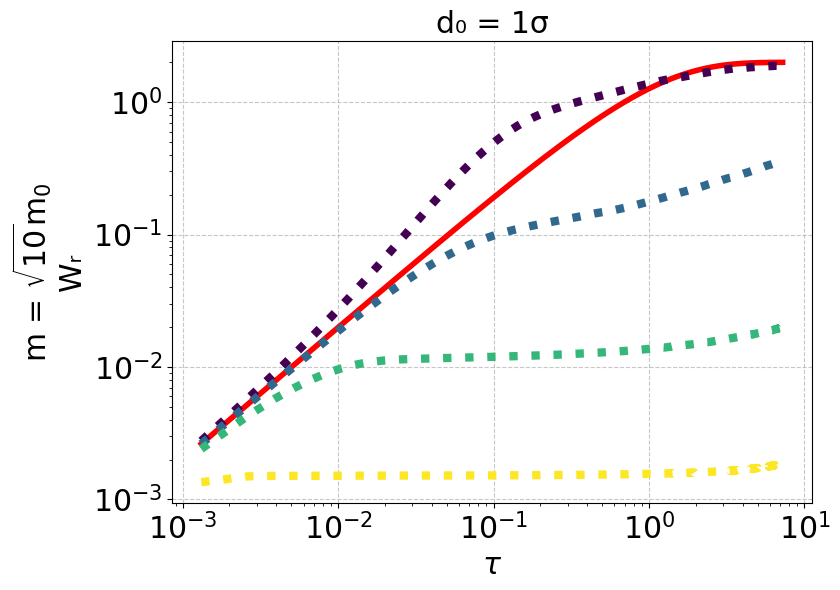

d₀ = 2


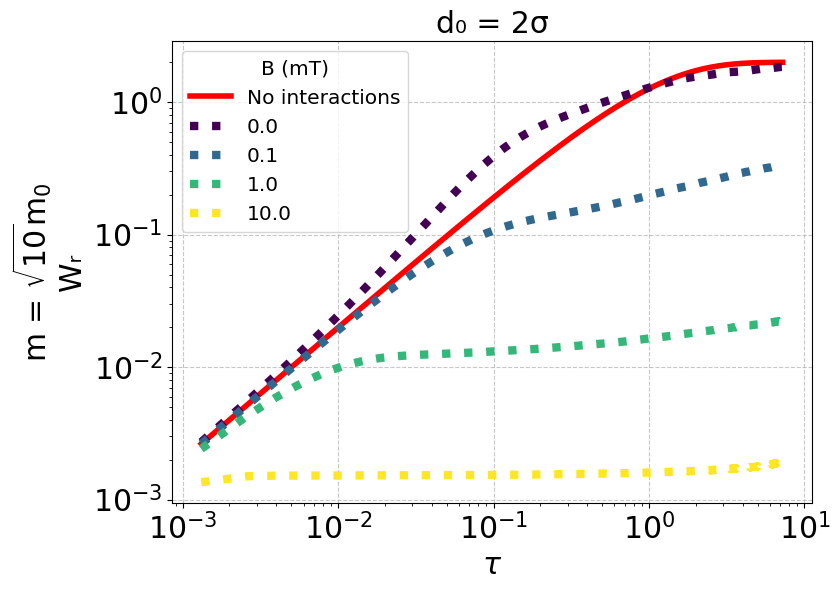

In [ ]:
# Necessary constants
k = 1.38e-23  # Boltzmann constant (J/K)
K0 = k * T
Dt = K0 / (3 * np.pi * eta * sigma)  # Translational diffusion coefficient
Dr = K0 / (np.pi * eta * sigma**3)  # Rotational diffusion coefficient

# Plot the MSD for rotational motion
for separation in separation_values:
    print(f"d₀ = {separation}")
    if separation==1:
        legend = False
    elif separation==2:
        legend = True
    f.plot_MSD(N, steps, iterations, separation, B_values, 
                sigma, v, T, eta,
                type_msd='rot', loglog=True, start=1, figsize=(8.5,6), 
                dipole_moment='$\sqrt{{10}}$', legend=legend
                )

### 5.5. Difussion Coefficient

#### 5.5.1. Translational

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\iesus\AppData\Local\Temp\ipykernel_15384\3465198870.py:13: SyntaxWarning: invalid escape sequence '\s'
  dipole_moment = '$\sqrt{10}$'
C:\Users\iesus\AppData\Local\Temp\ipykernel_15384\3465198870.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = get_cmap('viridis')(np.linspace(0, 1, len(B_values)))
C:\Users\iesus\AppData\Local\Temp\ipykernel_15384\3465198870.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = get_cmap('viridis')(np.linspace(0, 1, len(B_values)))


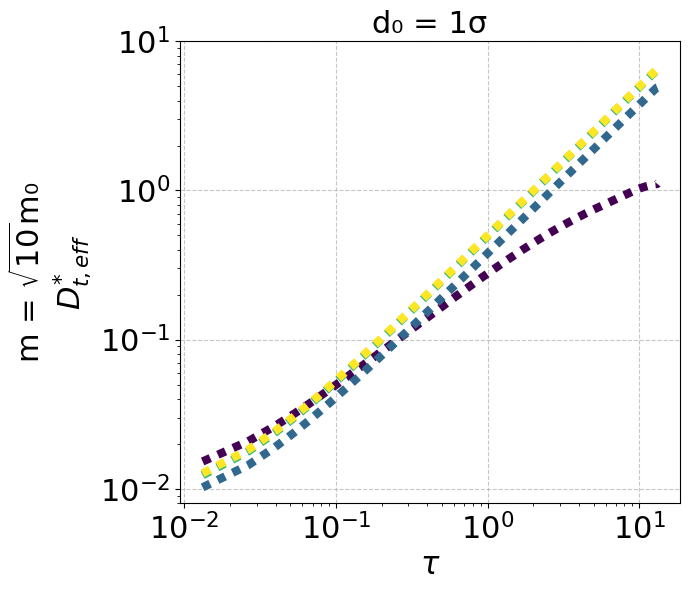

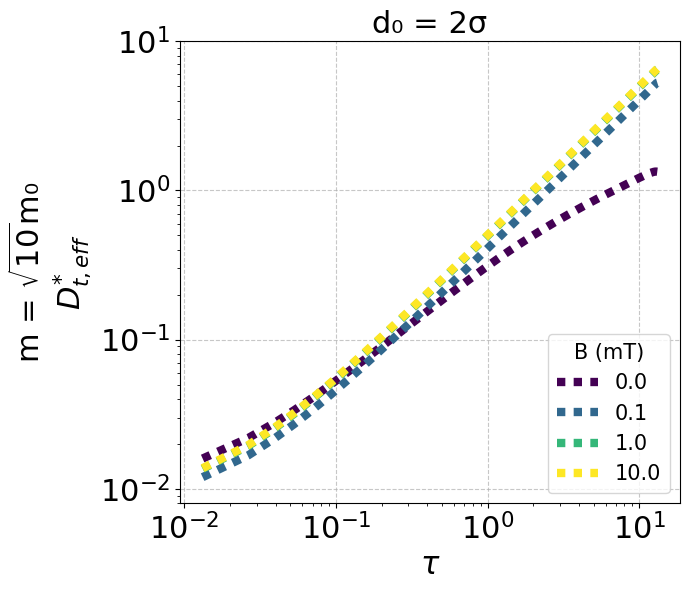

In [ ]:
# Plot the translational diffusion coefficient
from matplotlib.cm import get_cmap

type_msd = 'tra'  # 'tra' for translational, 'rot' for rotational
DATA_DIR = 'tra_msd_all_B.csv'

for separation in separation_values:

    plt.figure(figsize=(7,6))
    fontsize = 22
    linewidth = 4
    labelfont=fontsize - 4

    dipole_moment = '$\sqrt{10}$'

    Dt_eff = (Dt + v**2 / (2 * Dr))/(Dt)

    # Load the data
    ROOT_DIR = f'msd_{N}part_{steps // 1000}ksteps_{iterations}its_{separation}sep'
    FILE_PATH = os.path.join(ROOT_DIR, DATA_DIR)

    df = pd.read_csv(FILE_PATH)[1:]  # Load data and skip the first 100 rows
    normalization_factor = 4 if type_msd == 'tra' else 4

    # Normalize and rename columns
    for i, B in enumerate(B_values):
        df.iloc[:, i + 2] = df.iloc[:, i + 2].astype(float) * sigma**2 / (normalization_factor * df['time'].astype(float) * Dt * Dt_eff)
        df.rename(columns={df.columns[i + 2]: f'{B * 1000:.2f} mT'}, inplace=True)

    # Drop unnecessary columns
    df.drop(columns=[f'{type_msd}_msd_smoluchowski'], inplace=True)

    # Use viridis colormap
    colors = get_cmap('viridis')(np.linspace(0, 1, len(B_values)))

    # Plot the Diffusion Coefficient
    for B, color in zip(B_values, colors):   
        plt.plot(df['time'] * Dr, df[f'{B * 1000:.2f} mT'], label=f'{B * 1000:.1f}',
                 color=color, linewidth=linewidth+2, linestyle=(0, (1, 1))) # \sim t for t > 1

    plt.xlabel('$\\tau$', fontsize=fontsize)
    plt.ylabel(f'm = {dipole_moment}m₀ \n'+'$D_{t,eff}^{*}$', fontsize=fontsize)
    
    plt.xscale('log')
    plt.yscale('log')

    plt.ylim(8e-3, 10)  # Set y-axis limits

    plt.title(f'd₀ = {separation}σ', fontsize=fontsize)
    plt.tick_params(axis='x', labelsize=fontsize)  # Change x-axis label size
    plt.tick_params(axis='y', labelsize=fontsize)  # Change y-axis label size

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()
    if separation == 2:
        plt.legend(fontsize=fontsize-7, title='B (mT)', title_fontsize=fontsize-7, loc='lower right')
    elif separation == 1:
        continue
    plt.show()


#### 5.5.2. Rotational

C:\Users\iesus\AppData\Local\Temp\ipykernel_5240\3331547715.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = get_cmap('viridis')(np.linspace(0, 1, len(B_values)))
C:\Users\iesus\AppData\Local\Temp\ipykernel_5240\3331547715.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = get_cmap('viridis')(np.linspace(0, 1, len(B_values)))


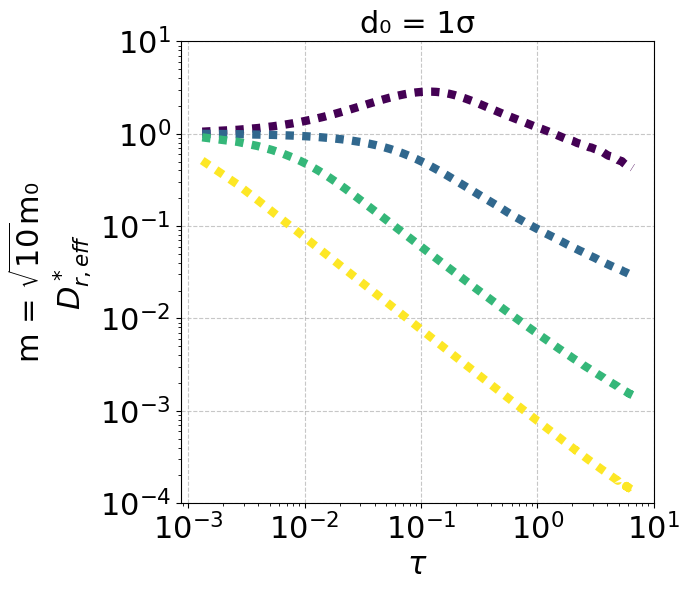

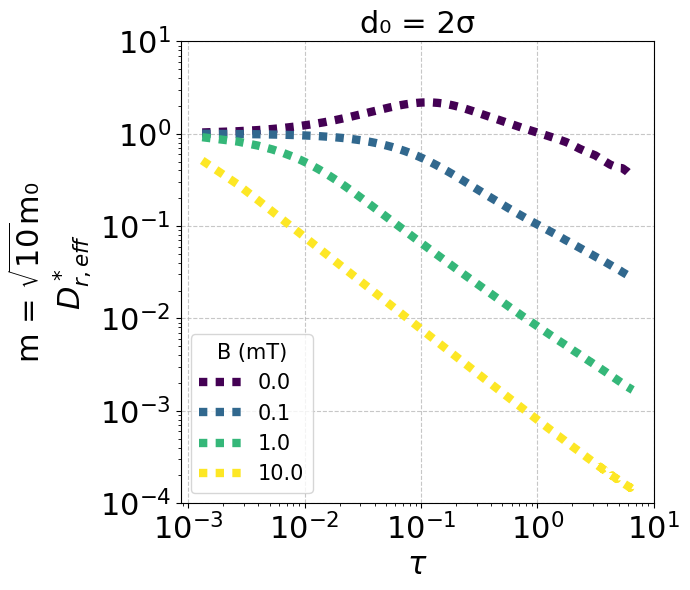

In [ ]:
# Plot the rotational difussion coefficient
from matplotlib.cm import get_cmap

type_msd = 'rot'  # 'tra' for translational, 'rot' for rotational
DATA_DIR = 'rot_msd_all_B.csv'

for separation in separation_values:

    plt.figure(figsize=(7,6))
    fontsize = 22
    linewidth = 4
    labelfont=fontsize - 4

    dipole_moment = '$\\sqrt{10}$'

    # Load the datanorma
    ROOT_DIR = f'msd_{N}part_{steps // 1000}ksteps_{iterations}its_{separation}sep'
    FILE_PATH = os.path.join(ROOT_DIR, DATA_DIR)

    df = pd.read_csv(FILE_PATH)[1:5000]  # Load data and skip the first 100 rows
    normalization_factor = 4 if type_msd == 'tra' else 2

    # Normalize and rename columns
    for i, B in enumerate(B_values):
        df.iloc[:, i + 2] = - np.log(1 - 0.5 * df.iloc[:, i + 2].astype(float)) / ( df['time'].astype(float) * Dr)
        df.rename(columns={df.columns[i + 2]: f'{B * 1000:.2f} mT'}, inplace=True)

    # Drop unnecessary columns
    df.drop(columns=[f'{type_msd}_msd_smoluchowski'], inplace=True)

    # Use viridis colormap
    colors = get_cmap('viridis')(np.linspace(0, 1, len(B_values)))

    # Plot the Diffusion Coefficient
    for B, color in zip(B_values, colors):   
        plt.plot(df['time'] * Dr, df[f'{B * 1000:.2f} mT'], label=f'{B * 1000:.1f}',
                 color=color, linewidth=linewidth+2, linestyle=(0, (1, 1))) # \sim t for t > 1

    plt.xlabel('$\\tau$', fontsize=fontsize)
    plt.ylabel(f'm = {dipole_moment}m₀ \n'+'$D_{r,eff}^*$', fontsize=fontsize)
    plt.xscale('log')
    plt.yscale('log')

    plt.ylim(1e-4,10)
    plt.title(f'd₀ = {separation}σ', fontsize=fontsize)

    #plt.yscale('log')
    plt.tick_params(axis='x', labelsize=fontsize)  # Change x-axis label size
    plt.tick_params(axis='y', labelsize=fontsize)  # Change y-axis label size

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()
    if separation == 2:
        plt.legend(fontsize=fontsize-7, title='B (mT)', title_fontsize=fontsize-7)
    elif separation == 1:
        continue
    plt.show()

## 6. Structure Analysis

### 6.1. Structure Factor

In [10]:
# Calculate the structure factor
"""num_wavevector_steps = 250
chunk_size = 50

for separation in [2]:
    for n_step in n_steps_values:
        f.calculate_structure_factor(N, steps, iterations, separation, sigma, B_values, 
                           n_step, v, num_wavevector_steps=250, batch_size=100, chunk_size=50)
        print(f"Structure factor for separation {separation} and time step {n_step}")

        """

'num_wavevector_steps = 250\nchunk_size = 50\n\nfor separation in [2]:\n    for n_step in n_steps_values:\n        f.calculate_structure_factor(N, steps, iterations, separation, sigma, B_values, \n                           n_step, v, num_wavevector_steps=250, batch_size=100, chunk_size=50)\n        print(f"Structure factor for separation {separation} and time step {n_step}")\n\n        '

d0 = 1σ, Time = 0.000 s


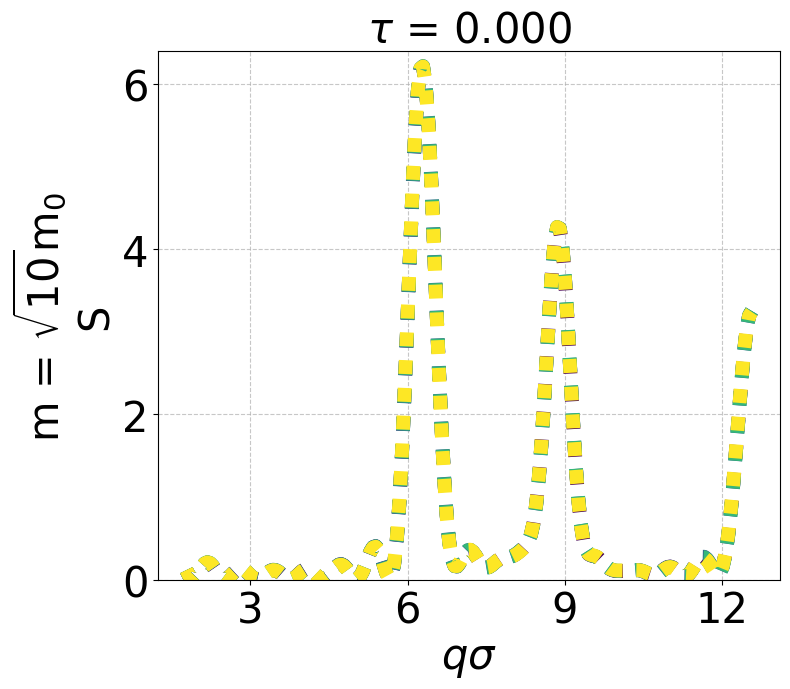

d0 = 1σ, Time = 0.001 s


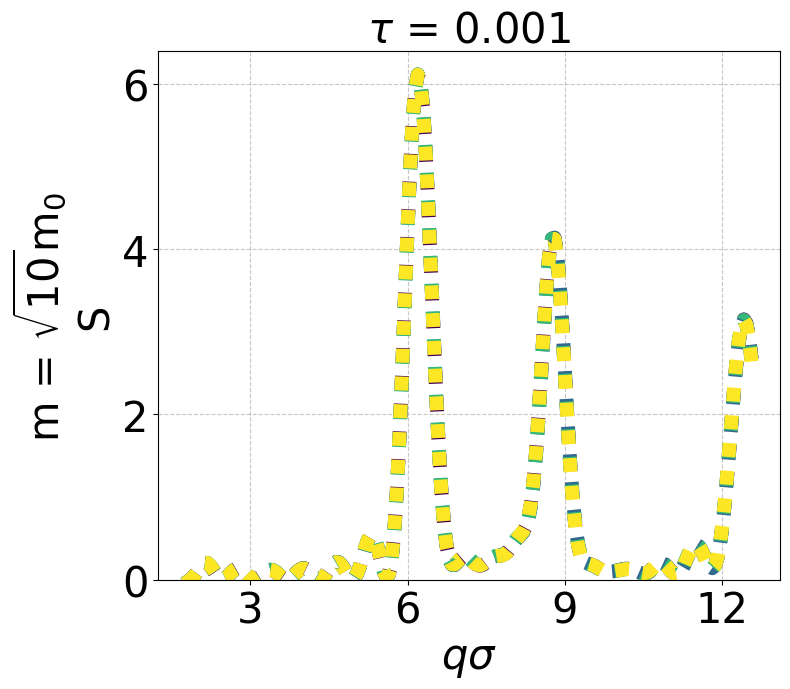

d0 = 1σ, Time = 0.010 s


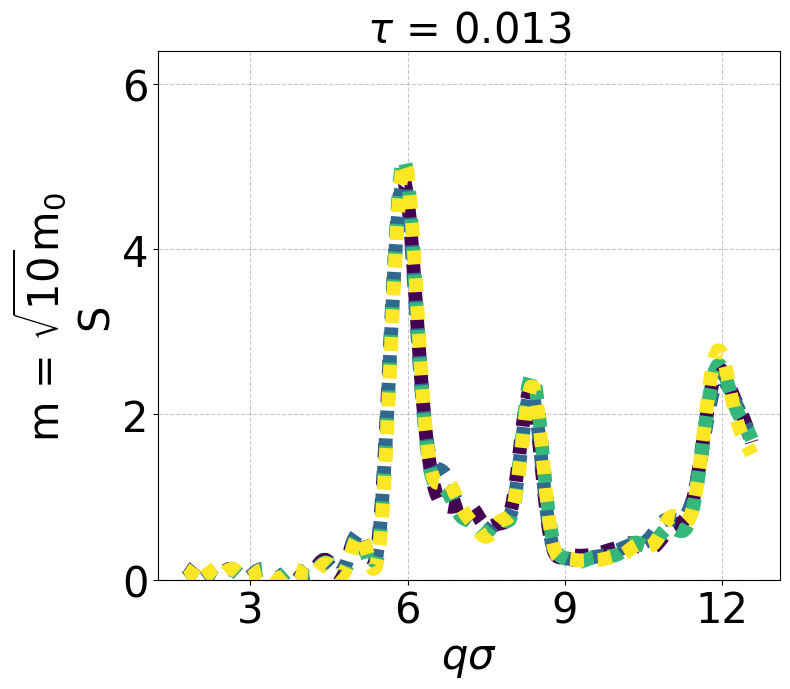

d0 = 1σ, Time = 0.100 s


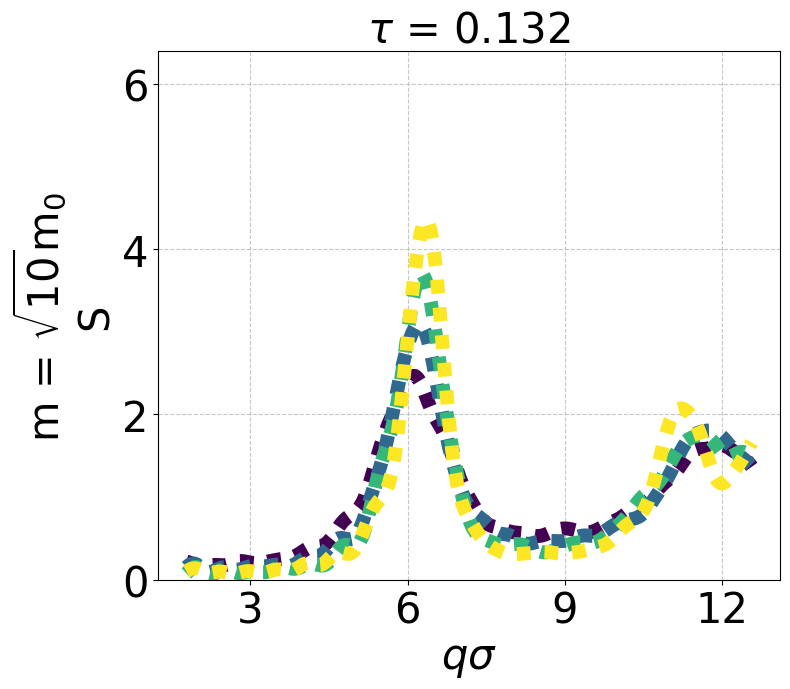

d0 = 1σ, Time = 1.000 s


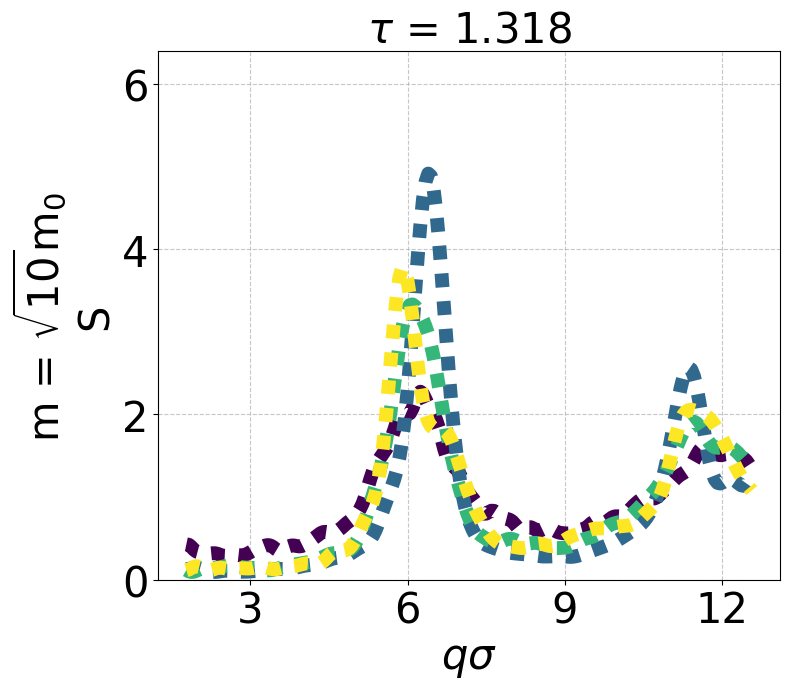

d0 = 1σ, Time = 10.000 s


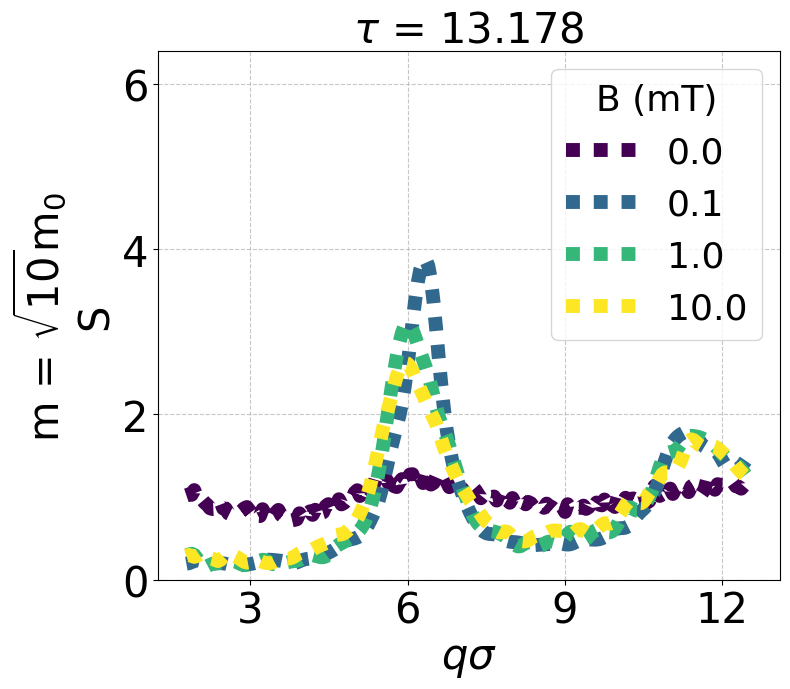

d0 = 2σ, Time = 0.000 s


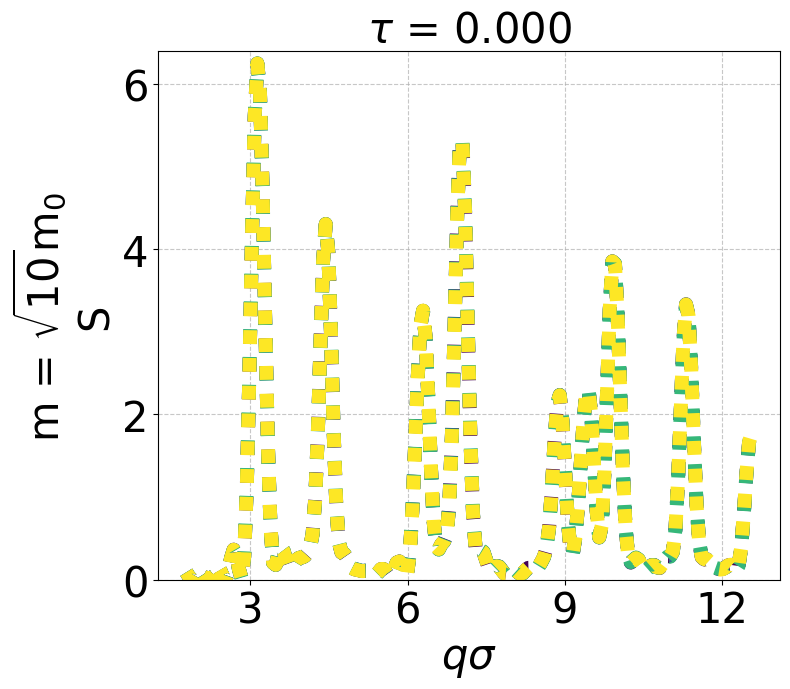

d0 = 2σ, Time = 0.001 s


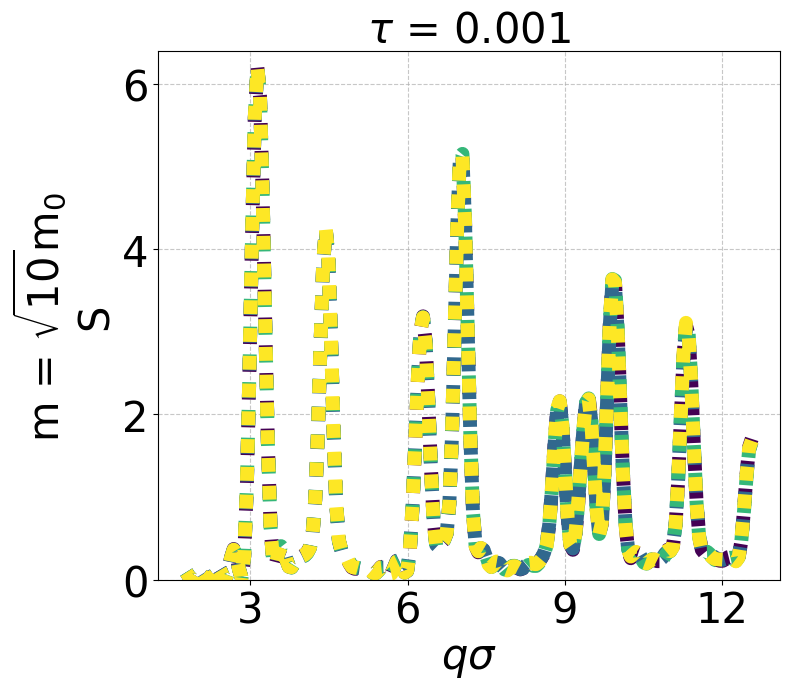

d0 = 2σ, Time = 0.010 s


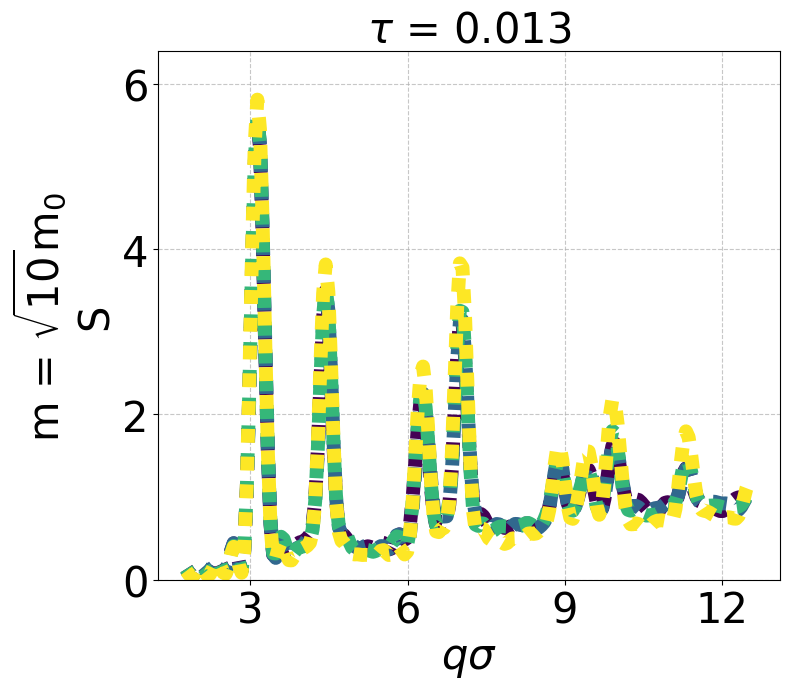

d0 = 2σ, Time = 0.100 s


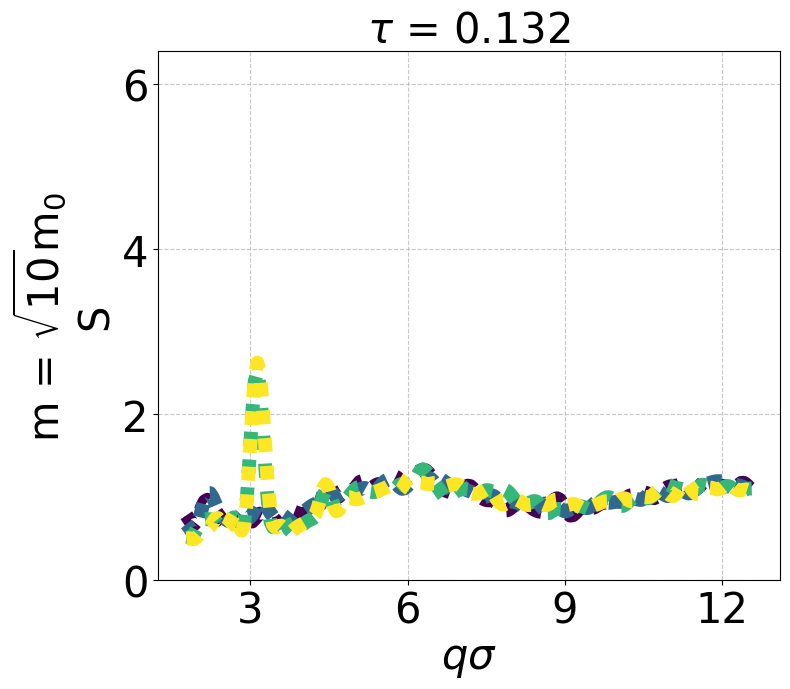

d0 = 2σ, Time = 1.000 s


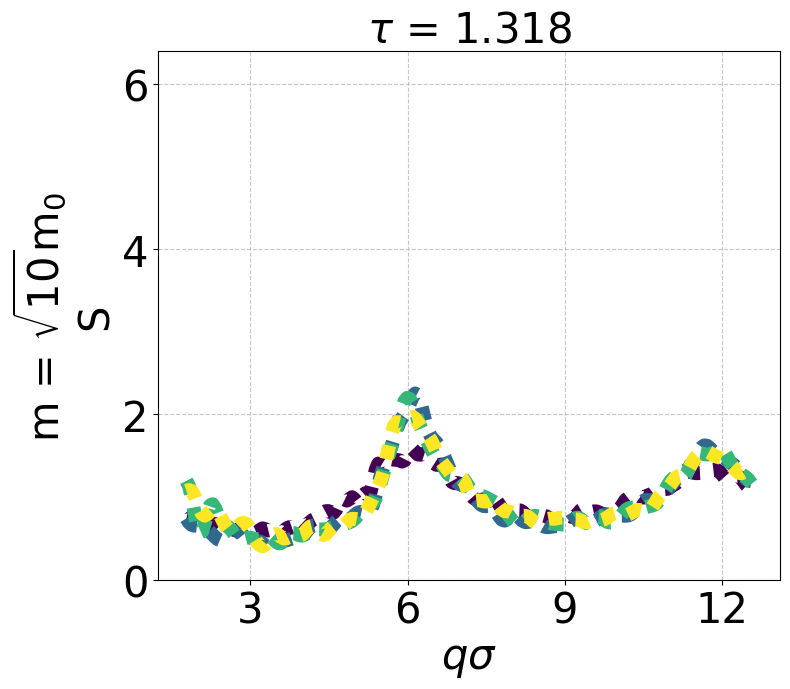

d0 = 2σ, Time = 10.000 s


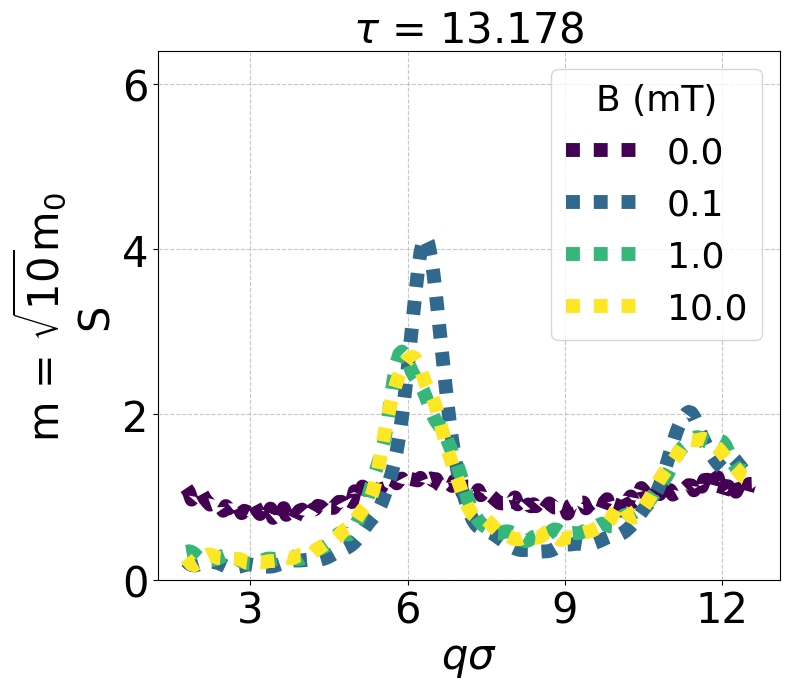

In [ ]:
# Plot the structure factor
brown = True
for separation in separation_values:
    for n_step in n_steps_values:
        print(f"d0 = {separation}σ, Time = {n_step*dt:.3f} s")
        if n_step == steps:
            label = True
        else:
            label = False
        # Calculate structure factor for each separation and time step
        f.plot_structure_factors(N, steps, iterations, separation, B_values, n_step, 
                           eta, sigma, v, dt, T, mm, start=35, end=None, figsize=(8,7), dipole_moment='$\\sqrt{{10}}$', label=label)

### 6.2. Distributions (PDFs)

In [11]:
"""for separation in separation_values:
    for n_step in n_steps_values:
        print(f"d₀ = {separation}σ, Time = {n_step*dt:.3f} s")
        # Calculate and plot KDE for each separation and time step
        f.calculate_kde_phi_data(N=N, steps=steps, iterations=iterations, 
                               B_values=B_values, separation=separation, n_step=n_step, overwrite=True)"""

'for separation in separation_values:\n    for n_step in n_steps_values:\n        print(f"d₀ = {separation}σ, Time = {n_step*dt:.3f} s")\n        # Calculate and plot KDE for each separation and time step\n        f.calculate_kde_phi_data(N=N, steps=steps, iterations=iterations, \n                               B_values=B_values, separation=separation, n_step=n_step, overwrite=True)'

d₀ = 1σ, Time = 0.000 s


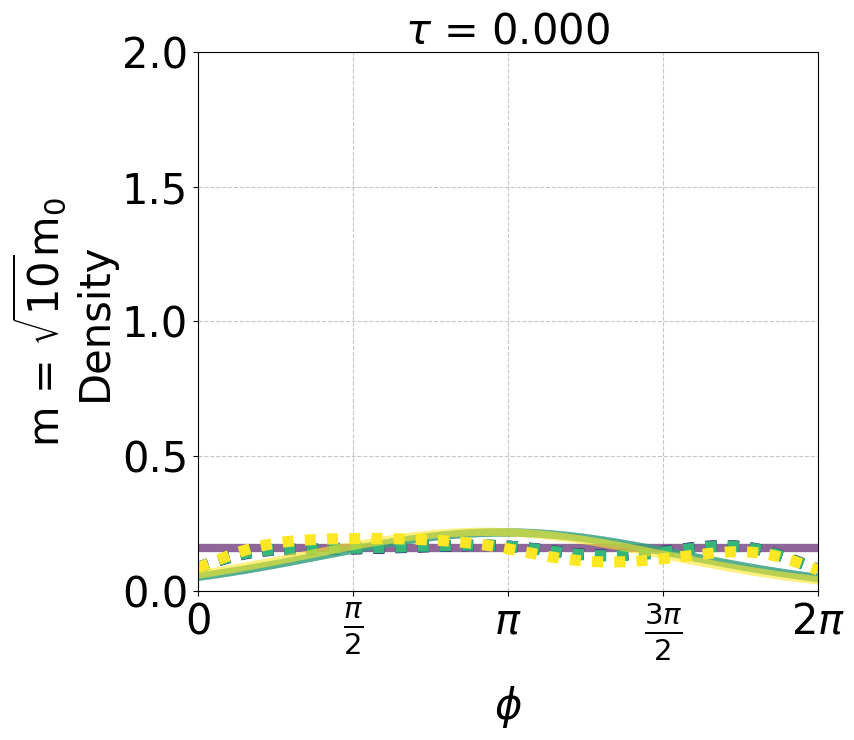

d₀ = 1σ, Time = 0.001 s


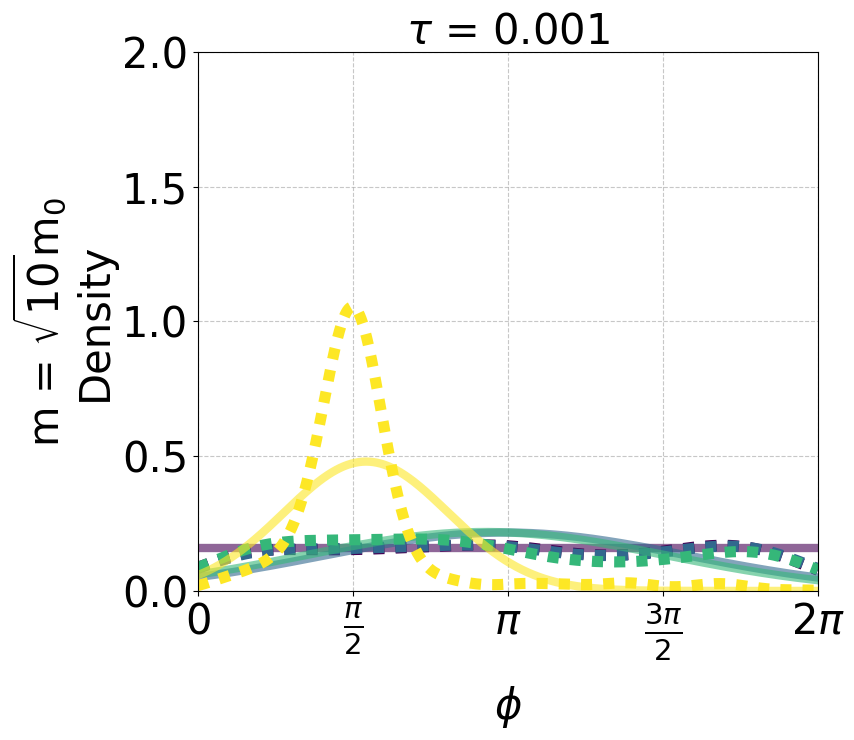

d₀ = 1σ, Time = 0.010 s


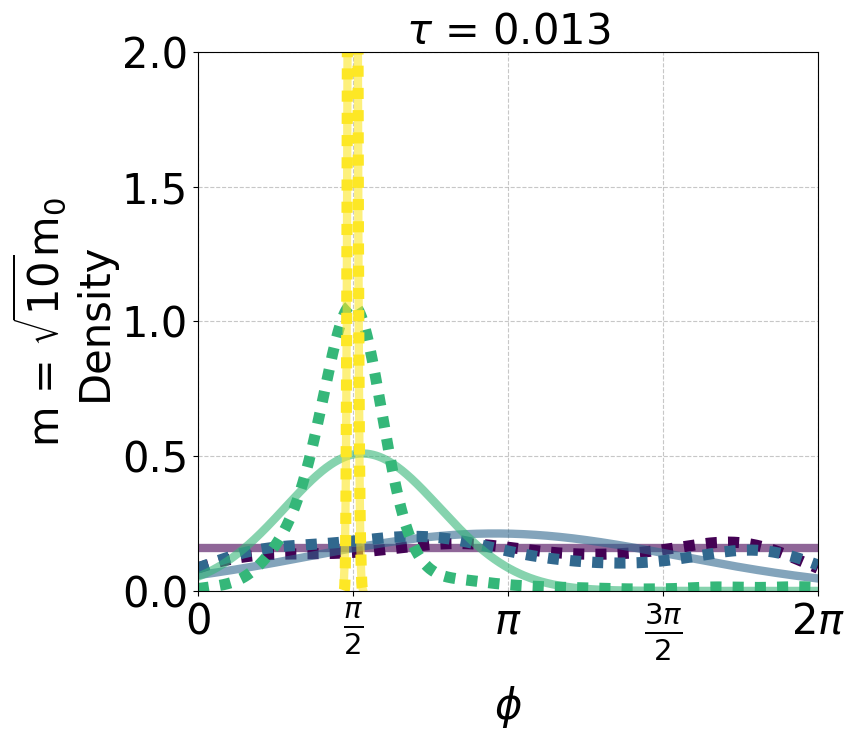

d₀ = 1σ, Time = 0.100 s


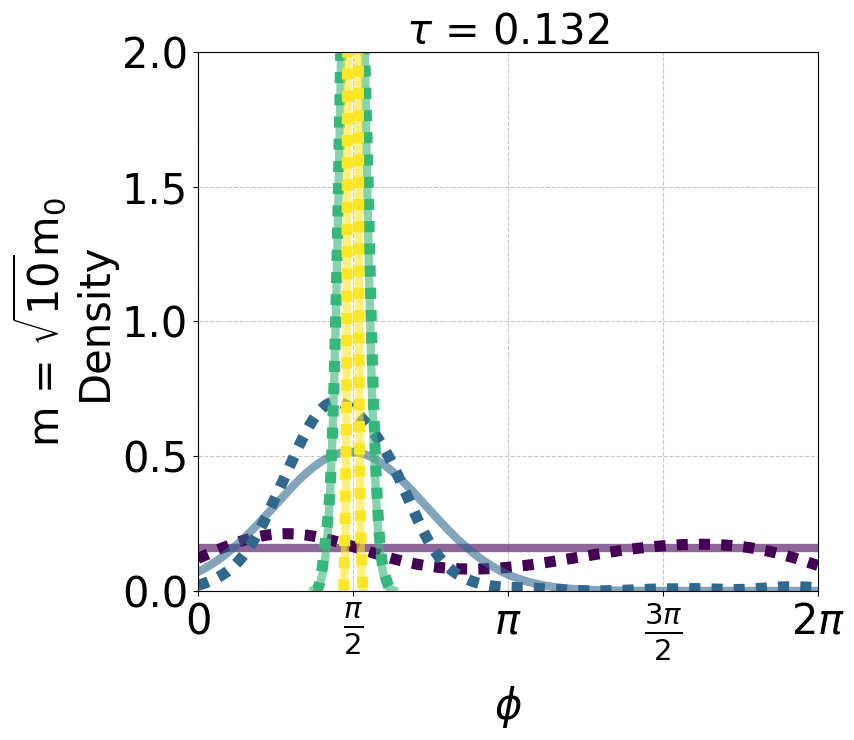

d₀ = 1σ, Time = 1.000 s


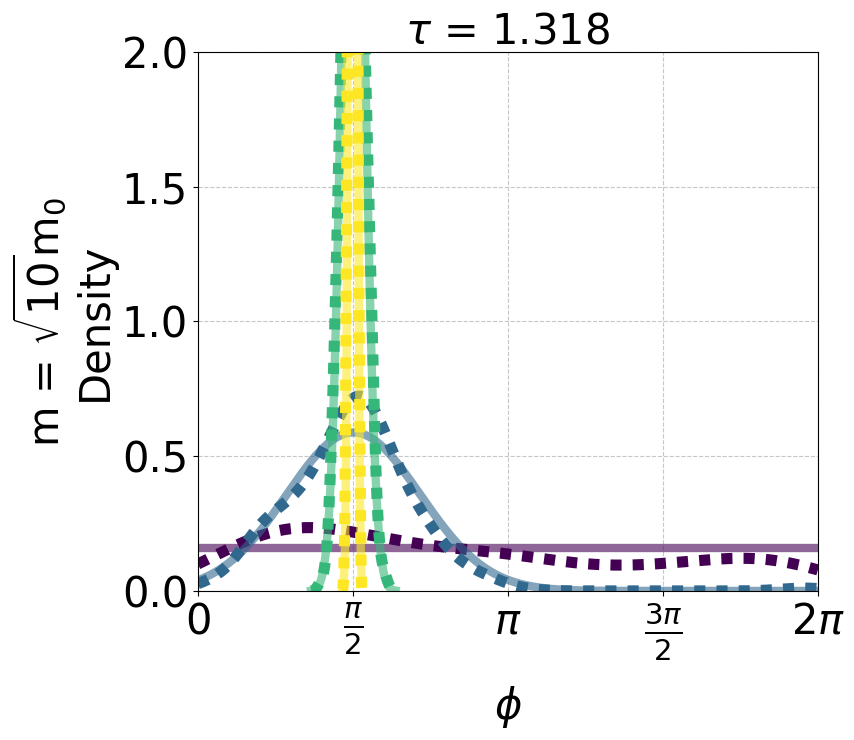

d₀ = 1σ, Time = 10.000 s


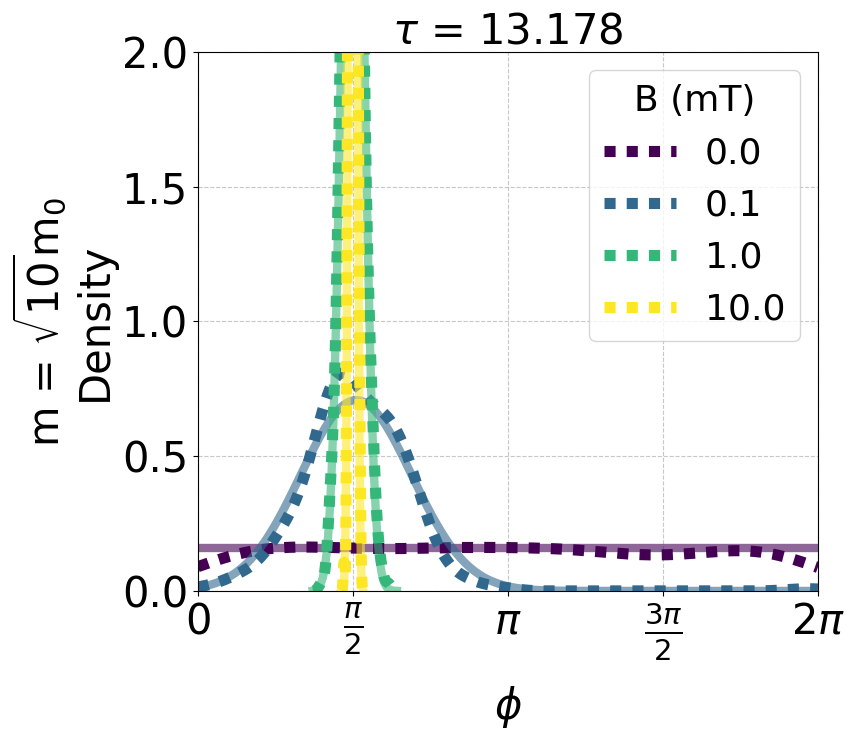

d₀ = 2σ, Time = 0.000 s


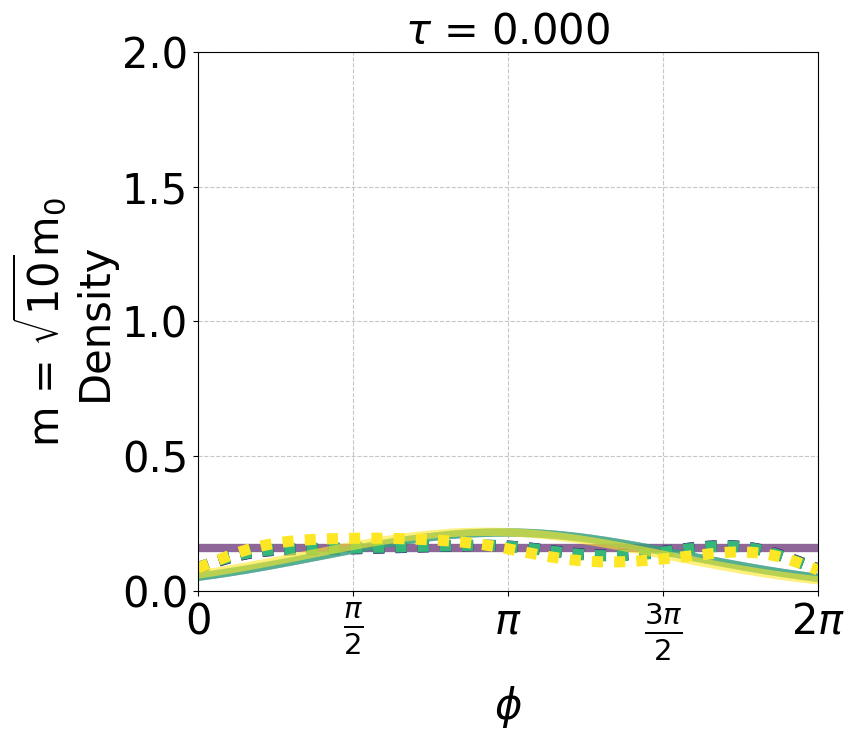

d₀ = 2σ, Time = 0.001 s


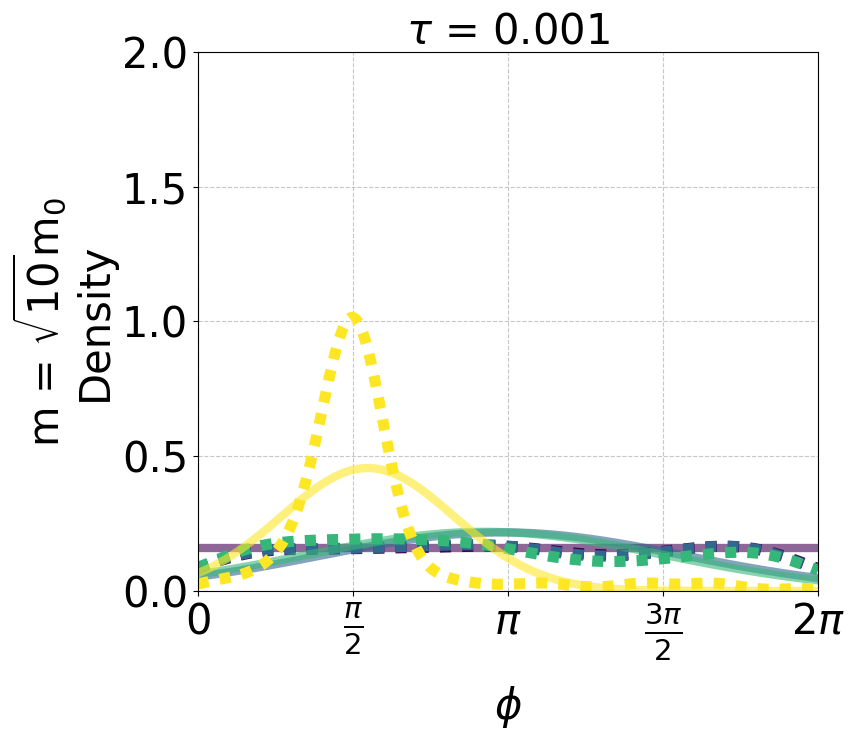

d₀ = 2σ, Time = 0.010 s


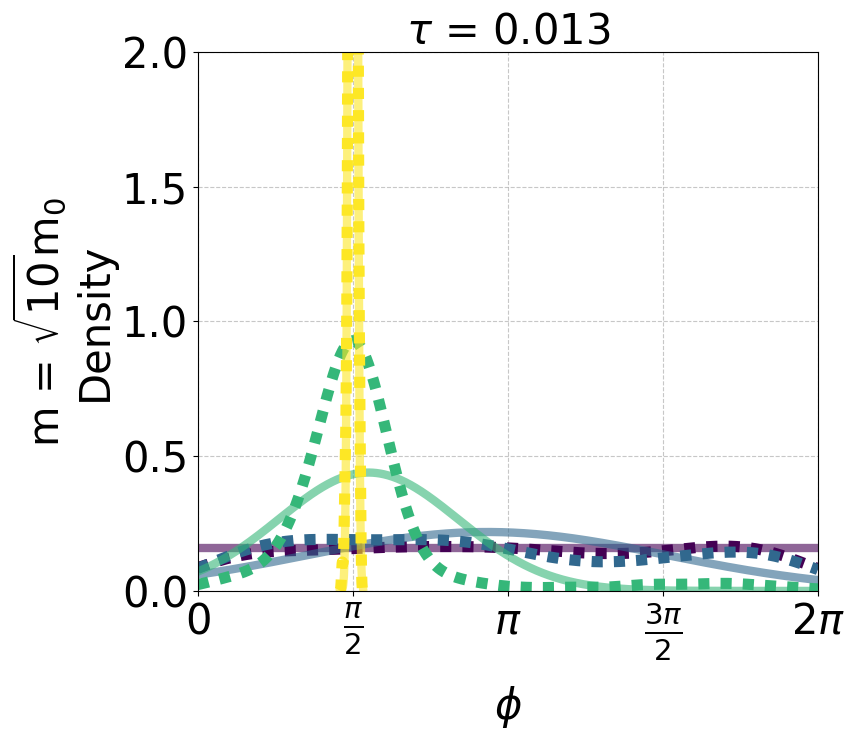

d₀ = 2σ, Time = 0.100 s


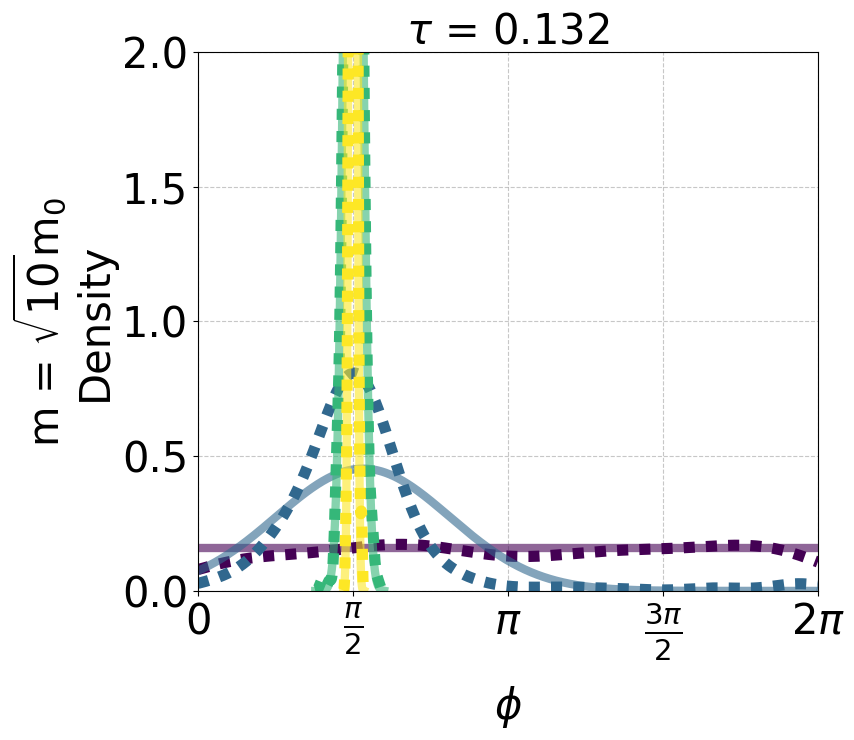

d₀ = 2σ, Time = 1.000 s


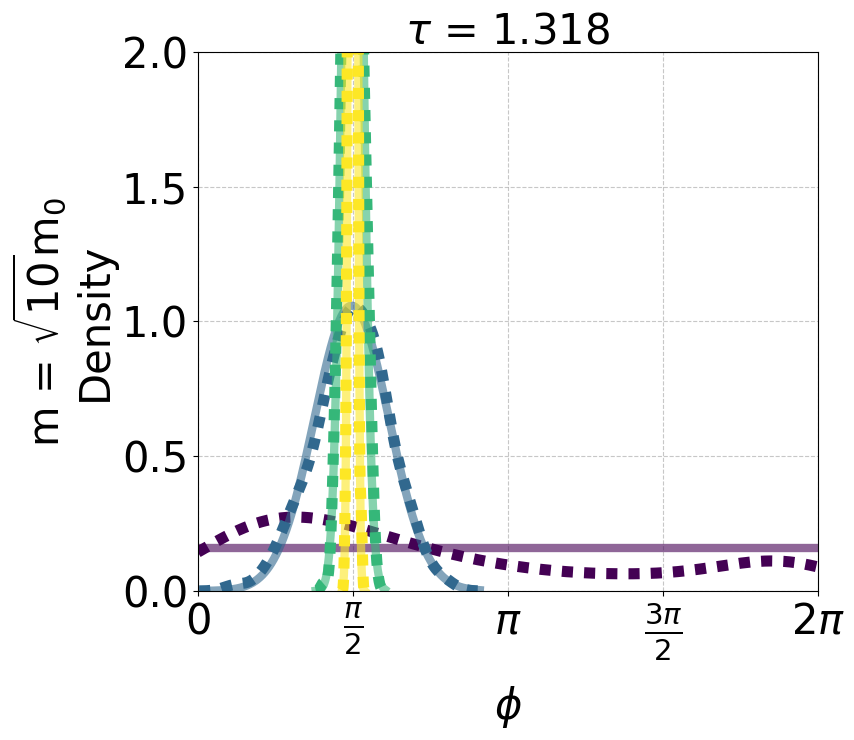

d₀ = 2σ, Time = 10.000 s


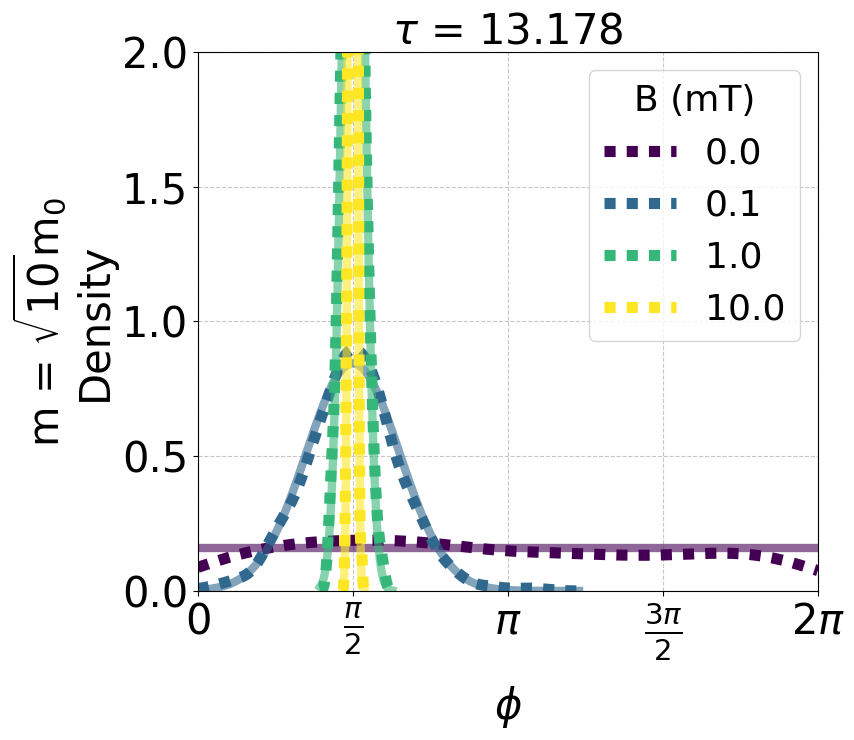

In [6]:
# Plot KDE for each separation and time step
for separation in separation_values:
    for n_step in n_steps_values:
        print(f'd₀ = {separation}σ, Time = {n_step*dt:.3f} s')
        if n_step == steps:
            label = True
        else:
            label = False
        # Calculate and plot KDE for each separation and time step
        f.plot_kde_phi_data(N=N, steps=steps, iterations=iterations, dt=dt,
                          B_values=B_values, eta=eta, sigma=sigma, T=T, dipole_moment='$\\sqrt{{10}}$', separation=separation, n_step=n_step,
                          figsize=(8, 7), ylimsup=2, normal_dist=True, label=label)

### 6.3. Global Hexagonal Bond Parameter

#### 6.3.1. Mean $\phi_6$

In [12]:
# Calculate global hexagonal order parameter
"""for separation in [1,2]:
    for n_step in [steps]:
        print(f"d₀ = {separation}σ, Time: {n_step*dt:.3f} s")
        # Calculate global hexagonal order parameter for each separation and time step
        f.calculate_global_hexagonal_order(N, steps, iterations, separation, sigma, B_values, 
                                   n_step, v, rc=1.5, batch_size=100)"""

'for separation in [1,2]:\n    for n_step in [steps]:\n        print(f"d₀ = {separation}σ, Time: {n_step*dt:.3f} s")\n        # Calculate global hexagonal order parameter for each separation and time step\n        f.calculate_global_hexagonal_order(N, steps, iterations, separation, sigma, B_values, \n                                   n_step, v, rc=1.5, batch_size=100)'

#### 6.3.2. Snapshot (Local)

In [13]:
# Calculate and plot phi6 data for different separations and time steps
"""for separation in separation_values:
    f.calculate_local_phi6(N, steps, iterations, separation=separation, sigma=sigma, B_values=B_values, n_step=steps, rc=3, batch_size=100)"""

'for separation in separation_values:\n    f.calculate_local_phi6(N, steps, iterations, separation=separation, sigma=sigma, B_values=B_values, n_step=steps, rc=3, batch_size=100)'

d₀ = 1σ, B = 0.0 mT


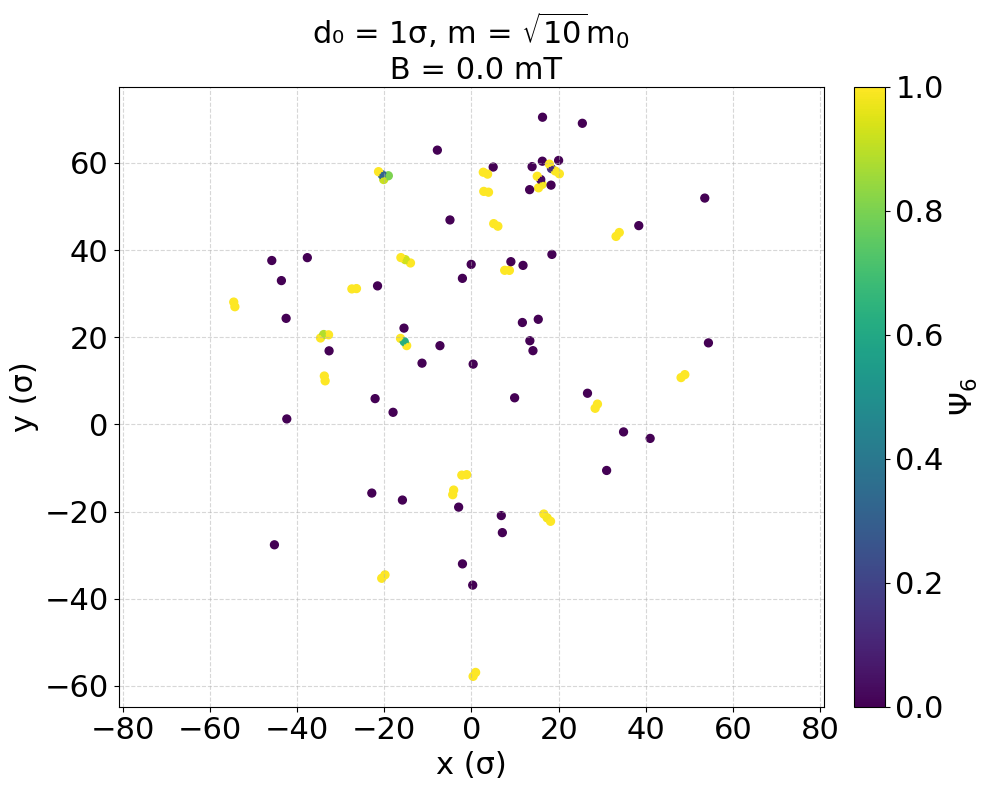

d₀ = 1σ, B = 0.1 mT


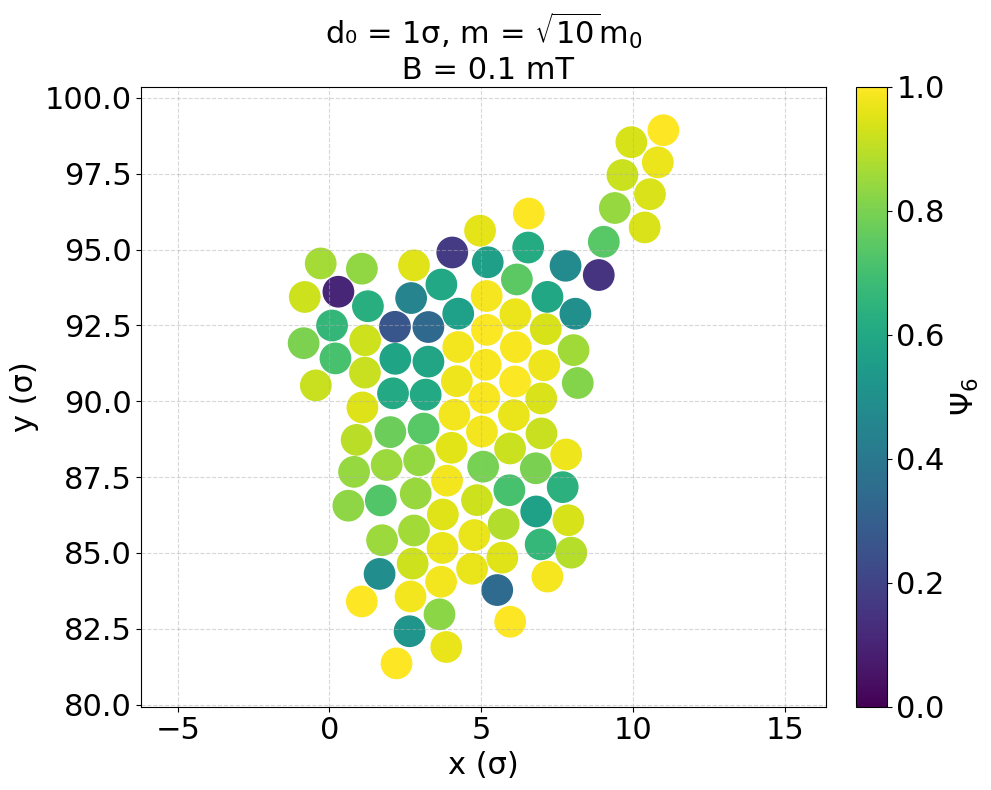

d₀ = 1σ, B = 1.0 mT


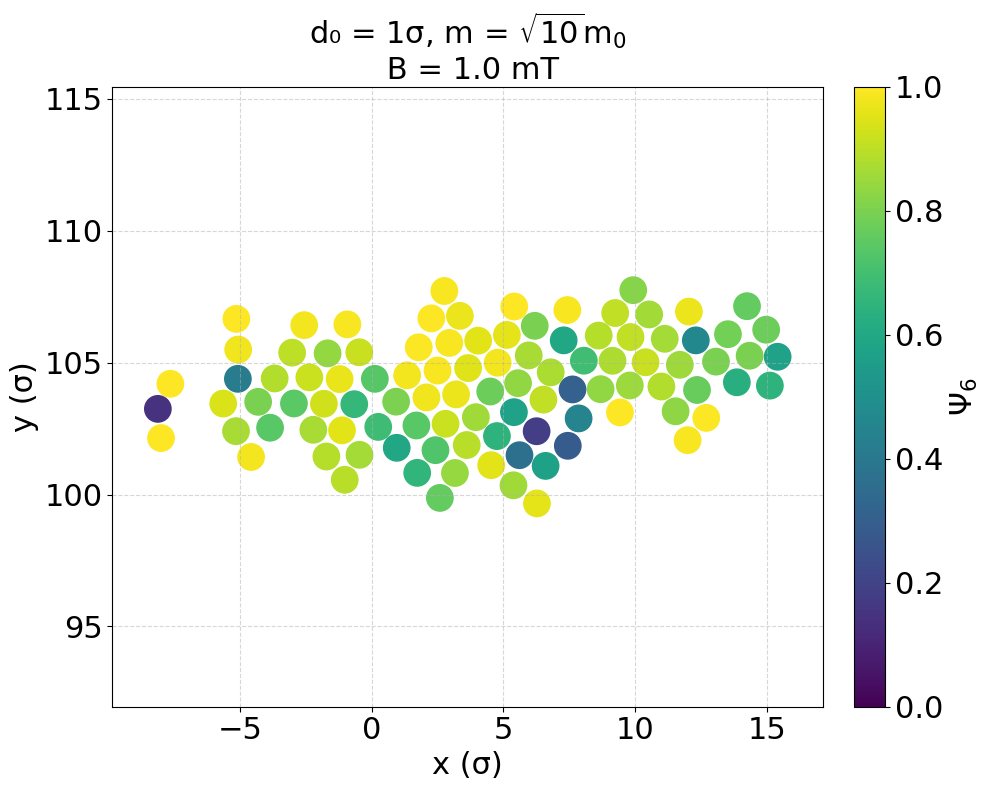

d₀ = 1σ, B = 10.0 mT


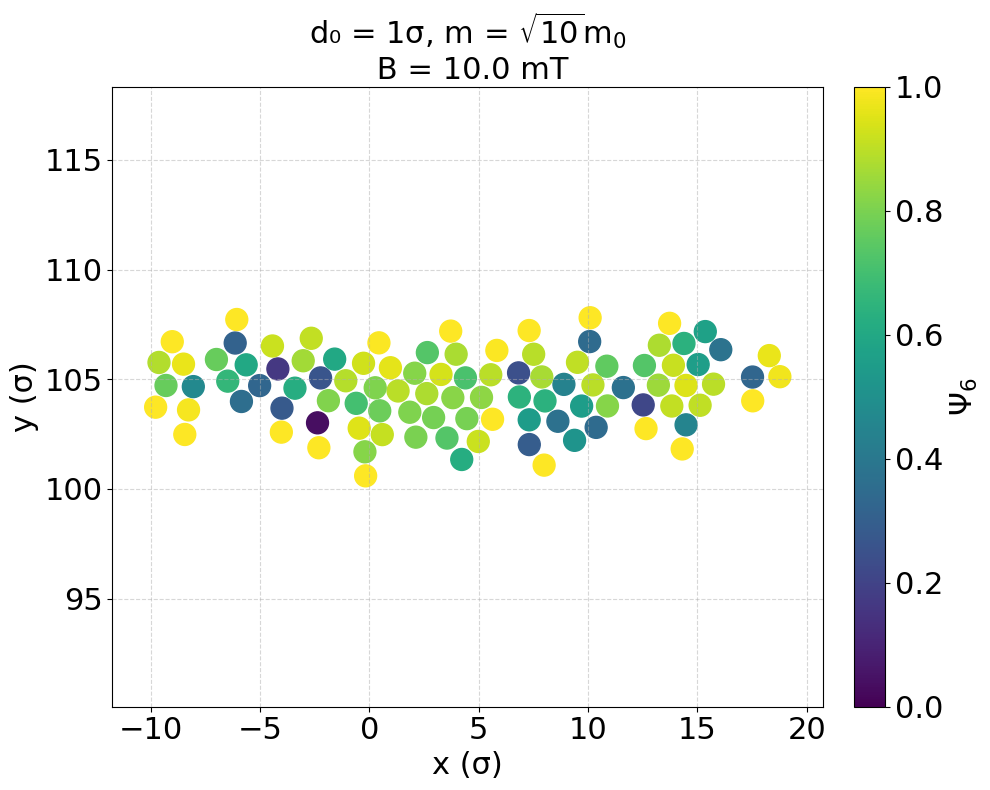

d₀ = 2σ, B = 0.0 mT


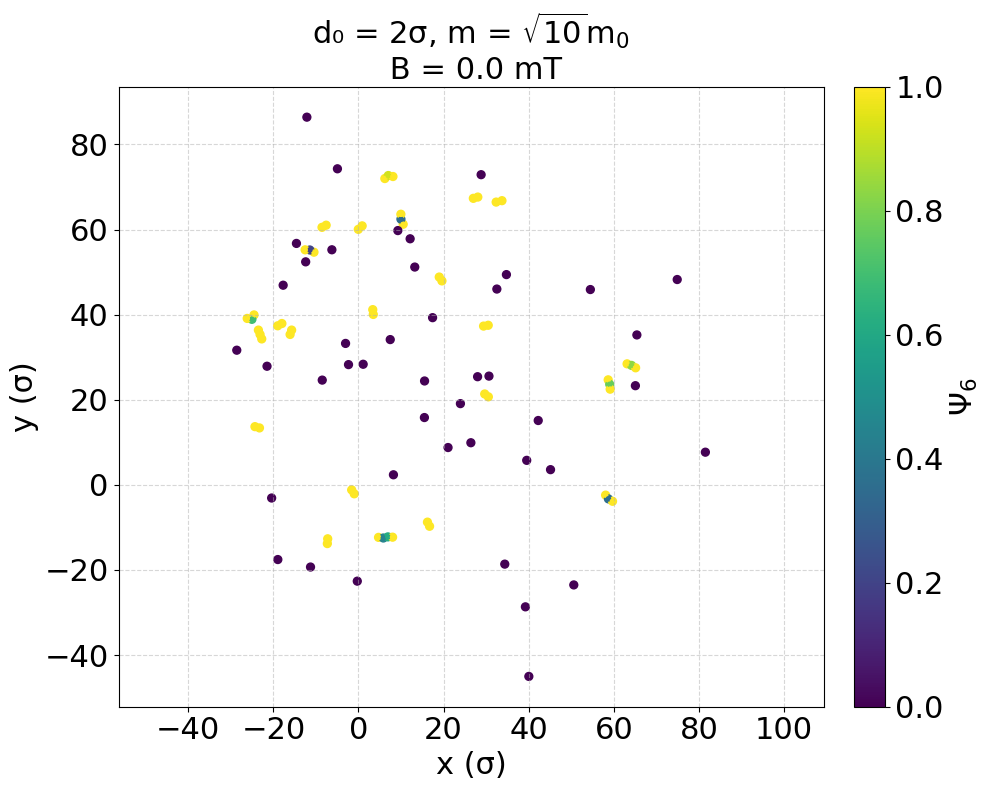

d₀ = 2σ, B = 0.1 mT


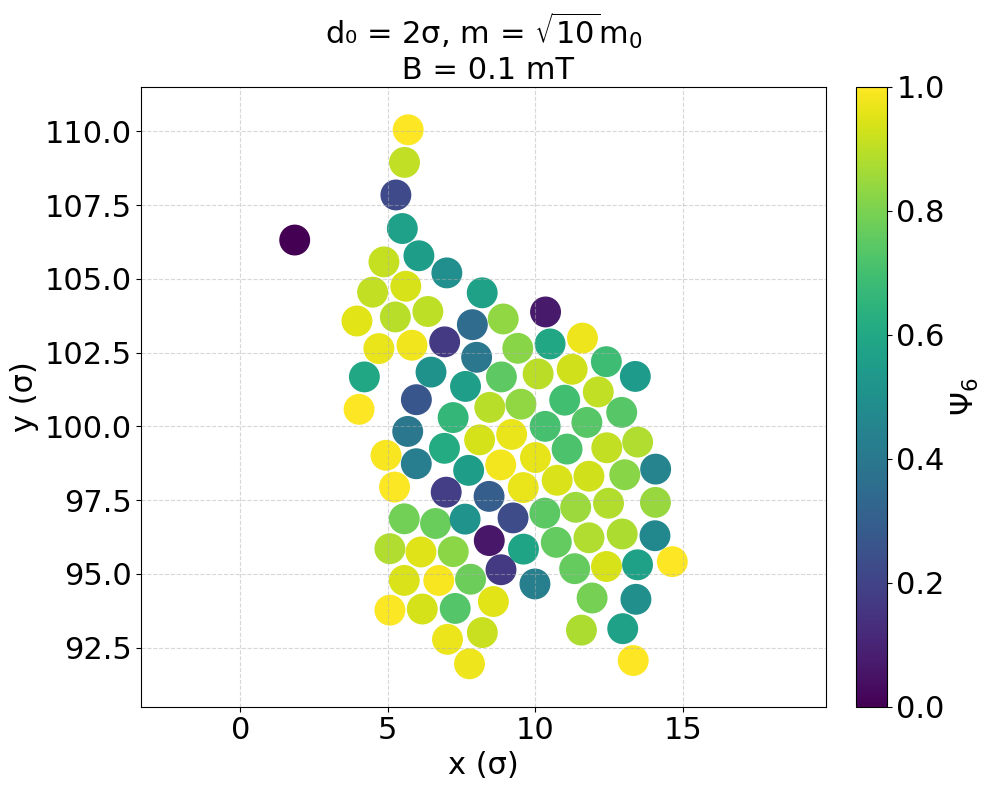

d₀ = 2σ, B = 1.0 mT


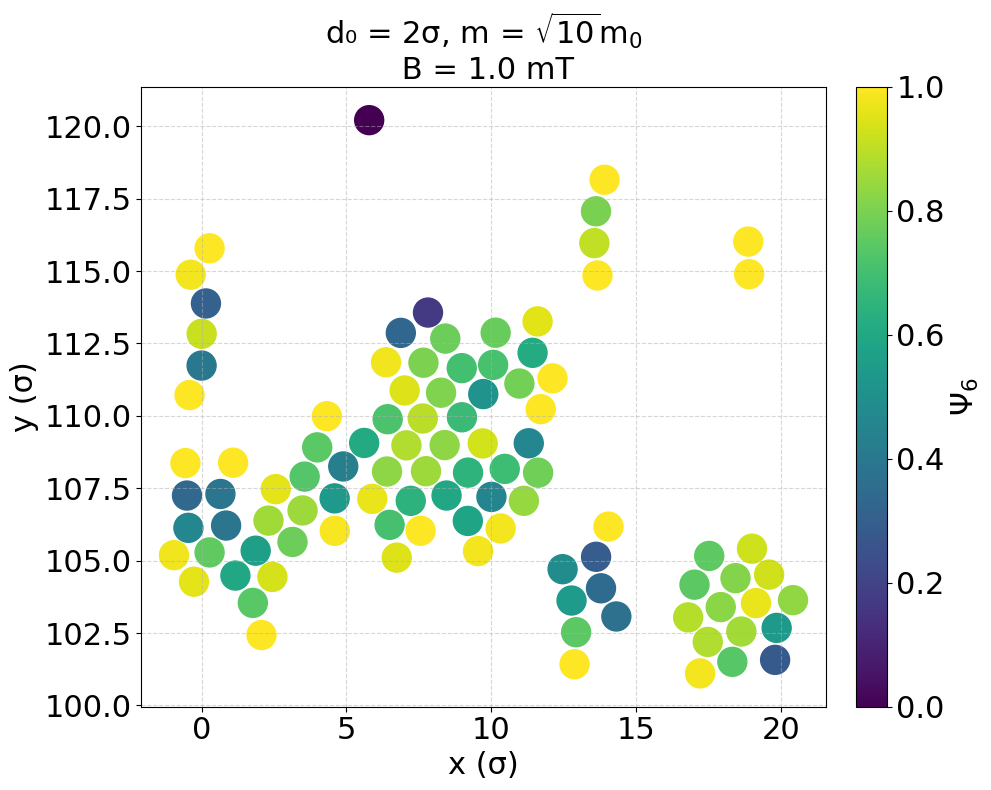

d₀ = 2σ, B = 10.0 mT


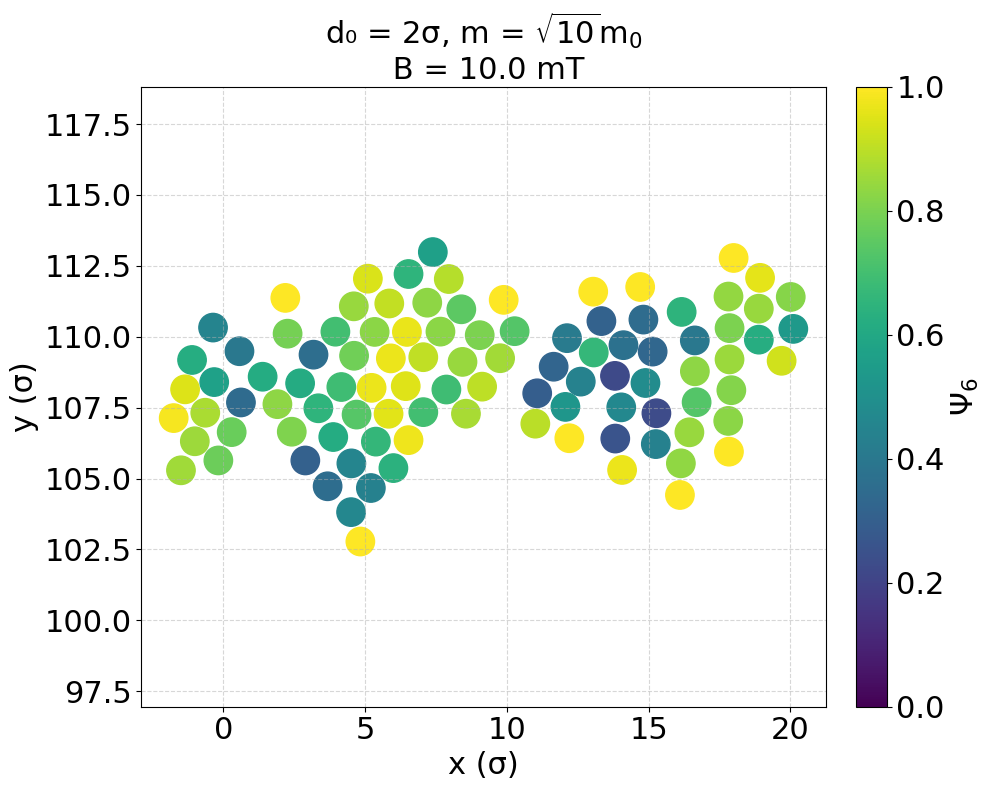

In [ ]:
# Plot phi6 data for different separations and time steps
for separation in separation_values:
    for B in B_values:
        print(f'd₀ = {separation}σ, B = {B*1000:.1f} mT')
        # Calculate and plot phi6 data for different separations and time steps
        f.plot_phi6_snapshot(N=N, steps=steps, iterations=iterations, iteration=1, separation=separation, 
                             sigma=sigma, B=B, n_step=100_000, rc=1.5, dipole_moment='$\\sqrt{{10}}$')

### 6.5. Cluster size

In [14]:
# Calculate cluster size distribution
"""for separation in separation_values:
    for n_step in [steps]:
        print(f'd₀ = {separation}σ, Time = {n_step*dt:.3f} s')
        # Calculate cluster sizes
        f.calculate_cluster_size_distribution(N, steps, iterations, separation, sigma, B_values, 
                                     n_step, rc=r_cl, bandwidth=7, min_cluster_size=1)"""

"for separation in separation_values:\n    for n_step in [steps]:\n        print(f'd₀ = {separation}σ, Time = {n_step*dt:.3f} s')\n        # Calculate cluster sizes\n        f.calculate_cluster_size_distribution(N, steps, iterations, separation, sigma, B_values, \n                                     n_step, rc=r_cl, bandwidth=7, min_cluster_size=1)"

In [10]:
n_steps_values 

[1, 10, 100, 1000, 10000, 100000]

d₀ = 1σ


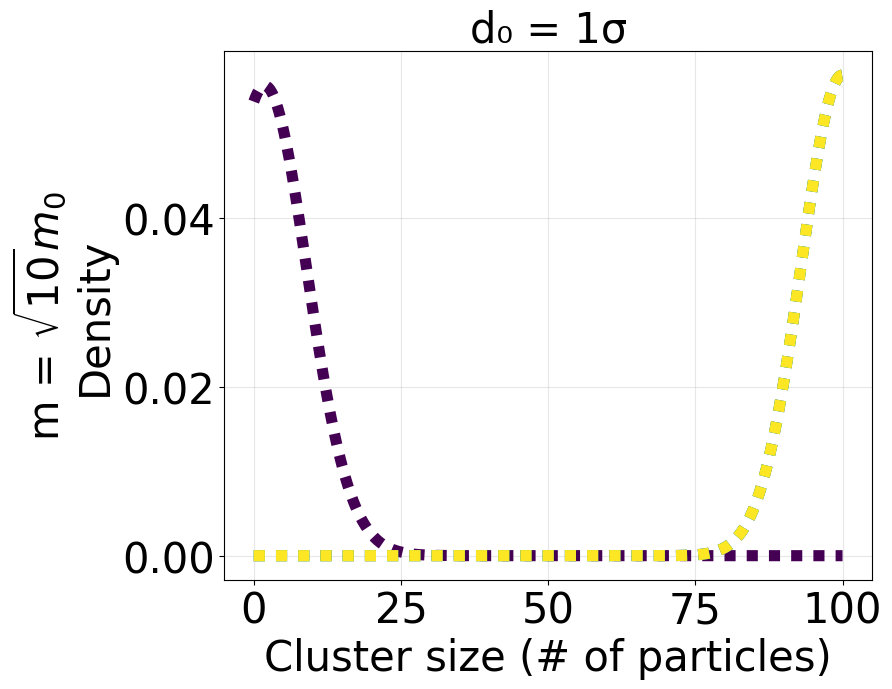

d₀ = 2σ


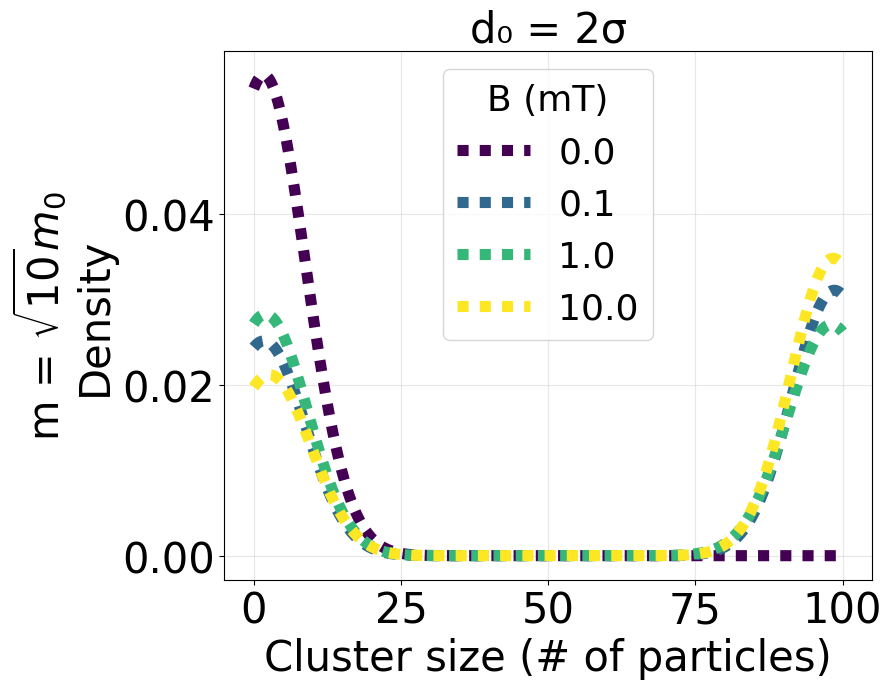

In [11]:
# Plot cluster sizes
for separation in separation_values:
    for n_step in [steps]:
        print(f'd₀ = {separation}σ')
        # Plot cluster sizes
        if separation==1:
            legend = False
        elif separation==2:
            legend = True
        f.plot_cluster_size_distribution(N, steps, iterations, separation, B_values, dt, Dr, n_step=n_step,
                                         figsize=(9, 7), ylim=None, legend=legend)

## 6.6. Percentage of Free Particles

In [ ]:
# Calculate free particles from clusters
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

def calculate_free_particles_from_clusters(N, steps, iterations, separation, B_values, n_step):
    """
    Calculate the percentage of free particles (not in any cluster) from cluster distribution data.
    
    Args:
        N (int): Number of particles
        steps (int): Total simulation steps
        iterations (int): Number of simulation repetitions
        separation (float): Initial separation between particles
        B_values (array-like): Array of magnetic field values (in Tesla)
        n_step (int): Time step to analyze
        
    Returns:
        None (saves results to CSV files)
    """
    # Directory where cluster data is stored
    input_dir = f'cluster_distribution_{N}part_{int(steps/1000)}ksteps_{iterations}its_{separation}sep'
    
    # Create output directory for free particles results
    output_dir = f'free_particles_{N}part_{int(steps/1000)}ksteps_{iterations}its_{separation}sep'
    os.makedirs(output_dir, exist_ok=True)
    
    # Prepare results storage
    results = []
    
    for B in tqdm(B_values, desc="Calculating free particles"):
        B_mT = B * 1000  # Convert to mT
        total_particles = N * iterations
        total_free_particles = 0
        
        # Load cluster sizes data
        cluster_file = os.path.join(input_dir, f'cluster_sizes_{B_mT:.1f}mT_{n_step}step.csv')
        
        try:
            # Read cluster sizes (empty file means all particles are free)
            if os.path.exists(cluster_file) and os.path.getsize(cluster_file) > 0:
                cluster_sizes = np.loadtxt(cluster_file, delimiter=',', dtype=int)
                
                # Calculate particles in clusters
                particles_in_clusters = np.sum(cluster_sizes)
                
                # Free particles = total particles - particles in clusters
                free_particles = total_particles - particles_in_clusters
            else:
                # If no clusters, all particles are free
                free_particles = total_particles
            
            # Calculate percentage
            percentage_free = (free_particles / total_particles) * 100
            
            results.append({
                'B_T': B,
                'B_mT': B_mT,
                'free_particles': free_particles,
                'total_particles': total_particles,
                'free_percentage': percentage_free,
                'n_step': n_step
            })
            
        except Exception as e:
            print(f"Error processing B={B_mT}mT: {str(e)}")
            continue
    
    # Save results to CSV
    results_df = pd.DataFrame(results)
    output_file = os.path.join(output_dir, f'free_particles_percentage_{n_step}step.csv')
    results_df.to_csv(output_file, index=False)
    
    
    print(f"Free particles percentage saved to {output_file}")
    return results


def plot_free_particles_percentage(N, steps, iterations, separation, n_step, figsize=(8, 6)):
    """
    Plot the percentage of free particles as a function of magnetic field.
    
    Args:
        N (int): Number of particles
        steps (int): Total simulation steps
        iterations (int): Number of simulation repetitions
        separation (float): Initial separation between particles
        n_step (int): Time step to analyze
        figsize (tuple): Figure size
    """
    # Directory where results are saved
    results_dir = f'free_particles_{N}part_{int(steps/1000)}ksteps_{iterations}its_{separation}sep'
    data_file = os.path.join(results_dir, f'free_particles_percentage_{n_step}step.csv')
    
    # Load data
    data = pd.read_csv(data_file)
    
    # Plot
    plt.figure(figsize=figsize)
    
    plt.plot(data['B_mT'], data['free_percentage'], 
             'o-', color='darkred', linewidth=2, markersize=8)
    
    plt.xlabel('Magnetic field (mT)', fontsize=14)
    plt.ylabel('Free particles (%)', fontsize=14)
    plt.title(f'Percentage of free particles at step {n_step}\n(N={N}, {iterations} iterations)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)  # Percentage scale
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [15]:
"""for separation in [1,2]:
    for n_step in [steps]:
        print(f'd₀ = {separation}σ, Time = {n_step*dt:.3f} s')
        # Calculate free particles from clusters
        calculate_free_particles_from_clusters(N, steps, iterations, separation, B_values, n_step)
        # Plot free particles percentage
        plot_free_particles_percentage(N, steps, iterations, separation, n_step)"""

"for separation in [1,2]:\n    for n_step in [steps]:\n        print(f'd₀ = {separation}σ, Time = {n_step*dt:.3f} s')\n        # Calculate free particles from clusters\n        calculate_free_particles_from_clusters(N, steps, iterations, separation, B_values, n_step)\n        # Plot free particles percentage\n        plot_free_particles_percentage(N, steps, iterations, separation, n_step)"